This work is developed using the codes in IntroMLLab and MAST-ML in NanoHub.

    Machine Learning Lab Module (IntroMLLab): 
https://www.nanohub.org/resources/intromllab

    Materials Simulation Toolkit for Machine Learning (MAST-ML): 
https://www.nanohub.org/resources/mastmltutorial

https://github.com/uw-cmg/MAST-ML

Here we import the MAST-ML modules

In [1]:
## for kaggle:
#!pip3 install mastml

In [1]:
from mastml.mastml import Mastml
from mastml.models import SklearnModel
from mastml.preprocessing import SklearnPreprocessor
from mastml.feature_selectors import SklearnFeatureSelector, EnsembleModelFeatureSelector
from mastml.data_splitters import SklearnDataSplitter#, NoSplit, LeaveOutPercent
from mastml.feature_generators import ElementalFeatureGenerator#, OneHotGroupGenerator
from mastml.hyper_opt import GridSearchCV#, GridSearch, RandomizedSearch, BayesianSearch
#from mastml.learning_curve import LearningCurve
from mastml.metrics import Metrics

import os
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from copy import copy
import mastml
import random

import sklearn.utils
from sklearn import tree
from sklearn.model_selection import KFold, RepeatedKFold, train_test_split

from collections import Counter
import pymatgen

Using TensorFlow backend.


In [160]:
#savepath = '../'
# to specify a folder name:
savepath = 'MASTML_FeaturesBandGap_04_28_03_56_03' 

# if not specified, let mastml create a folder:
if savepath=='':
    mastml = Mastml(savepath=SAVEPATH)
    savepath = mastml.get_savepath
    print('Saving to: '+ savepath)

In [4]:
seed = 12345123
np.random.seed(seed)
sklearn.utils.check_random_state(seed)

In [158]:
#### https://citrination.com/data_views/787/matrix_search?from=0

## Change this line for a new data set
dataFile = 'citrination-export.csv' 

mastml_df = pd.read_csv(dataFile)
mastml_df

Chemical formula       Band gap       Crystallinity       Color
0     Bi$_{2}$Te$_{3}$          0.153  Single crystalline         NaN
1           Mg$_{2}$Ge          0.567  Single crystalline         NaN
2                 CoSi          0.045  Single crystalline         NaN
3                 NaBr          7.025  Single crystalline         NaN
4           Ca$_{2}$Sn            0.9     Polycrystalline         NaN
5      As$_{2}$S$_{3}$           2.57  Single crystalline         NaN
6                  ZnO           3.35  Single crystalline         NaN
7           Cu$_{2}$Se           1.23  Single crystalline         NaN
8                 GeTe            0.7           Amorphous         NaN
9            CaF$_{2}$             10  Single crystalline         NaN
10                 DyN            2.1                 NaN         NaN
11    Sb$_{2}$Se$_{3}$           1.15     Polycrystalline         NaN
12                InAs          0.404  Single crystalline   Dark Gray
13           CdI$_{2}$            3.2  Single crystalline         NaN
14     La$_{2}$S$_{3}$           1.32     Polycrystalline  Red-Yellow
15    Mg$_{3}$Sb$_{2}$           0.82     Polycrystalline         NaN
16          Cu$_{2}$Te           1.15     Polycrystalline         NaN
17                PbTe           0.19  Single crystalline         NaN
18                CdSb          0.465                 NaN         NaN
19                 CaO            6.1  Single crystalline       White
20     As$_{2}$S$_{3}$              2           Amorphous         NaN
21          Mg$_{2}$Ge           0.57  Single crystalline         NaN
22                 CaS    6.0$\pm$0.2     Polycrystalline         NaN
23    Eu$_{3}$As$_{2}$            0.6  Single crystalline         NaN
24                AgBr          2.676  Single crystalline         NaN
25                ZnTe           2.35  Single crystalline         NaN
26          ZrSe$_{3}$           1.25  Single crystalline   Dark Gray
27    Cr$_{3}$Se$_{4}$          0.015                 NaN         NaN
28                 HgS            0.7  Single crystalline         NaN
29     Cr$_{2}$O$_{3}$           1.68  Single crystalline         NaN
...                ...            ...                 ...         ...
1419         ThO$_{2}$           5.02  Single crystalline         NaN
1420              ZnSb           1.09  Single crystalline         NaN
1421              InAs          0.412  Single crystalline         NaN
1422              HgSe           0.24  Single crystalline         NaN
1423         ZnI$_{2}$           4.53     Polycrystalline         NaN
1424               HgS           2.21     Polycrystalline         NaN
1425   Sb$_{2}$S$_{3}$           1.67  Single crystalline         NaN
1426  Mg$_{3}$As$_{2}$  2.55$\pm$0.35     Polycrystalline       Brown
1427               PbS          0.281  Single crystalline         NaN
1428              LiCl           9.33  Single crystalline         NaN
1429  As$_{2}$Se$_{3}$            1.5           Amorphous         NaN
1430   Sb$_{2}$S$_{3}$           1.69  Single crystalline         NaN
1431               LiI              6                 NaN         NaN
1432         BiF$_{3}$            NaN                 NaN        Gray
1433                 I            1.5  Single crystalline         NaN
1434        MnSe$_{2}$            0.2     Polycrystalline         NaN
1435        Na$_{2}$Te              2                 NaN         NaN
1436        Mg$_{2}$Ge           0.69  Single crystalline         NaN
1437  Cr$_{2}$Se$_{3}$          0.025                 NaN         NaN
1438   Er$_{2}$O$_{3}$           3.26     Polycrystalline         NaN
1439              NaCl            8.5  Single crystalline         NaN
1440   Ga$_{2}$O$_{3}$           4.54  Single crystalline         NaN
1441              PrSb           0.66     Polycrystalline         NaN
1442         PbI$_{2}$           2.41  Single crystalline         NaN
1443              CdSb           0.45  Single crystalline         NaN
1444            

In [191]:
# This section/example can be used to filter unnecessary/dirty columns or rows 
mastml_df_filtered = mastml_df.drop(columns=['Color']) ### Drops Color info
#mastml_df_filtered = mastml_df_filtered[mastml_df_filtered["Crystallinity"]=='Single crystalline'] ## Drops all material rows except "Single crystalline"
#mastml_df_filtered = mastml_df_filtered[mastml_df_filtered["Crystallinity"]=='Polycrystalline'] ## Drops all material rows except "Single crystalline"

mastml_df_filtered

Chemical formula       Band gap       Crystallinity
0     Bi$_{2}$Te$_{3}$          0.153  Single crystalline
1           Mg$_{2}$Ge          0.567  Single crystalline
2                 CoSi          0.045  Single crystalline
3                 NaBr          7.025  Single crystalline
4           Ca$_{2}$Sn            0.9     Polycrystalline
5      As$_{2}$S$_{3}$           2.57  Single crystalline
6                  ZnO           3.35  Single crystalline
7           Cu$_{2}$Se           1.23  Single crystalline
8                 GeTe            0.7           Amorphous
9            CaF$_{2}$             10  Single crystalline
10                 DyN            2.1                 NaN
11    Sb$_{2}$Se$_{3}$           1.15     Polycrystalline
12                InAs          0.404  Single crystalline
13           CdI$_{2}$            3.2  Single crystalline
14     La$_{2}$S$_{3}$           1.32     Polycrystalline
15    Mg$_{3}$Sb$_{2}$           0.82     Polycrystalline
16          Cu$_{2}$Te           1.15     Polycrystalline
17                PbTe           0.19  Single crystalline
18                CdSb          0.465                 NaN
19                 CaO            6.1  Single crystalline
20     As$_{2}$S$_{3}$              2           Amorphous
21          Mg$_{2}$Ge           0.57  Single crystalline
22                 CaS    6.0$\pm$0.2     Polycrystalline
23    Eu$_{3}$As$_{2}$            0.6  Single crystalline
24                AgBr          2.676  Single crystalline
25                ZnTe           2.35  Single crystalline
26          ZrSe$_{3}$           1.25  Single crystalline
27    Cr$_{3}$Se$_{4}$          0.015                 NaN
28                 HgS            0.7  Single crystalline
29     Cr$_{2}$O$_{3}$           1.68  Single crystalline
...                ...            ...                 ...
1419         ThO$_{2}$           5.02  Single crystalline
1420              ZnSb           1.09  Single crystalline
1421              InAs          0.412  Single crystalline
1422              HgSe           0.24  Single crystalline
1423         ZnI$_{2}$           4.53     Polycrystalline
1424               HgS           2.21     Polycrystalline
1425   Sb$_{2}$S$_{3}$           1.67  Single crystalline
1426  Mg$_{3}$As$_{2}$  2.55$\pm$0.35     Polycrystalline
1427               PbS          0.281  Single crystalline
1428              LiCl           9.33  Single crystalline
1429  As$_{2}$Se$_{3}$            1.5           Amorphous
1430   Sb$_{2}$S$_{3}$           1.69  Single crystalline
1431               LiI              6                 NaN
1432         BiF$_{3}$            NaN                 NaN
1433                 I            1.5  Single crystalline
1434        MnSe$_{2}$            0.2     Polycrystalline
1435        Na$_{2}$Te              2                 NaN
1436        Mg$_{2}$Ge           0.69  Single crystalline
1437  Cr$_{2}$Se$_{3}$          0.025                 NaN
1438   Er$_{2}$O$_{3}$           3.26     Polycrystalline
1439              NaCl            8.5  Single crystalline
1440   Ga$_{2}$O$_{3}$           4.54  Single crystalline
1441              PrSb           0.66     Polycrystalline
1442         PbI$_{2}$           2.41  Single crystalline
1443              CdSb           0.45  Single crystalline
1444                Te          0.334  Single crystalline
1445        NdTe$_{2}$           0.48                 NaN
1446   Nb$_{2}$S$_{3}$           0.12     Polycrystalline
1447         TiS$_{2}$           1.95  Single crystalline
1448  Tl$_{2}$Te$_{3}$            0.2                 NaN

[1449 rows x 3 columns]

In [193]:
mastml_df_filtered['Band gap'] = mastml_df_filtered['Band gap'].apply(pd.to_numeric, errors='coerce') ### Exclude rows that has ± sign
#mastml_df_filtered = mastml_df_filtered.drop('Band gap', axis=1).join(mastml_df_filtered['Band gap'].apply(pd.to_numeric, errors='coerce')) ### Find rows that has ± sign
mastml_df_filtered['Chemical formula'] = mastml_df_filtered['Chemical formula'].str.replace('[$_{}]','') #Convert subscripts to normal

mastml_df_filtered = mastml_df_filtered.dropna() ### Drops rows with empty values

mastml_df_filtered

Chemical formula  Band gap       Crystallinity
0              Bi2Te3     0.153  Single crystalline
1               Mg2Ge     0.567  Single crystalline
2                CoSi     0.045  Single crystalline
3                NaBr     7.025  Single crystalline
4               Ca2Sn     0.900     Polycrystalline
5               As2S3     2.570  Single crystalline
6                 ZnO     3.350  Single crystalline
7               Cu2Se     1.230  Single crystalline
8                GeTe     0.700           Amorphous
9                CaF2    10.000  Single crystalline
11             Sb2Se3     1.150     Polycrystalline
12               InAs     0.404  Single crystalline
13               CdI2     3.200  Single crystalline
14              La2S3     1.320     Polycrystalline
15             Mg3Sb2     0.820     Polycrystalline
16              Cu2Te     1.150     Polycrystalline
17               PbTe     0.190  Single crystalline
19                CaO     6.100  Single crystalline
20              As2S3     2.000           Amorphous
21              Mg2Ge     0.570  Single crystalline
23             Eu3As2     0.600  Single crystalline
24               AgBr     2.676  Single crystalline
25               ZnTe     2.350  Single crystalline
26              ZrSe3     1.250  Single crystalline
28                HgS     0.700  Single crystalline
29              Cr2O3     1.680  Single crystalline
30              GeSe2     2.690  Single crystalline
32               LaB6     4.100     Polycrystalline
33                MgO     7.770  Single crystalline
34              As2S3     2.800  Single crystalline
...               ...       ...                 ...
1411             HgSe     0.070  Single crystalline
1412               Si     1.120  Single crystalline
1413              NaI     6.750  Single crystalline
1414             PbTe     0.210  Single crystalline
1415              HgO     2.480     Polycrystalline
1417               UO     0.600     Polycrystalline
1418            Al2O3     8.700  Single crystalline
1419             ThO2     5.020  Single crystalline
1420             ZnSb     1.090  Single crystalline
1421             InAs     0.412  Single crystalline
1422             HgSe     0.240  Single crystalline
1423             ZnI2     4.530     Polycrystalline
1424              HgS     2.210     Polycrystalline
1425            Sb2S3     1.670  Single crystalline
1427              PbS     0.281  Single crystalline
1428             LiCl     9.330  Single crystalline
1429           As2Se3     1.500           Amorphous
1430            Sb2S3     1.690  Single crystalline
1433                I     1.500  Single crystalline
1434            MnSe2     0.200     Polycrystalline
1436            Mg2Ge     0.690  Single crystalline
1438            Er2O3     3.260     Polycrystalline
1439             NaCl     8.500  Single crystalline
1440            Ga2O3     4.540  Single crystalline
1441             PrSb     0.660     Polycrystalline
1442             PbI2     2.410  Single crystalline
1443             CdSb     0.450  Single crystalline
1444               Te     0.334  Single crystalline
1446            Nb2S3     0.120     Polycrystalline
1447             TiS2     1.950  Single crystalline

[1258 rows x 3 columns]

List of compounds that contain regex signs, such as ±

In [194]:
mastml_df_filtered[mastml_df_filtered['Band gap'].isna()] ### Show the formulas that has ± sign 

Empty DataFrame
Columns: [Chemical formula, Band gap, Crystallinity]
Index: []

In [195]:
### Exclude any rows with NaN, which formerly has regex
mastml_df_clean = mastml_df_filtered.dropna()
mastml_df_clean

Chemical formula  Band gap       Crystallinity
0              Bi2Te3     0.153  Single crystalline
1               Mg2Ge     0.567  Single crystalline
2                CoSi     0.045  Single crystalline
3                NaBr     7.025  Single crystalline
4               Ca2Sn     0.900     Polycrystalline
5               As2S3     2.570  Single crystalline
6                 ZnO     3.350  Single crystalline
7               Cu2Se     1.230  Single crystalline
8                GeTe     0.700           Amorphous
9                CaF2    10.000  Single crystalline
11             Sb2Se3     1.150     Polycrystalline
12               InAs     0.404  Single crystalline
13               CdI2     3.200  Single crystalline
14              La2S3     1.320     Polycrystalline
15             Mg3Sb2     0.820     Polycrystalline
16              Cu2Te     1.150     Polycrystalline
17               PbTe     0.190  Single crystalline
19                CaO     6.100  Single crystalline
20              As2S3     2.000           Amorphous
21              Mg2Ge     0.570  Single crystalline
23             Eu3As2     0.600  Single crystalline
24               AgBr     2.676  Single crystalline
25               ZnTe     2.350  Single crystalline
26              ZrSe3     1.250  Single crystalline
28                HgS     0.700  Single crystalline
29              Cr2O3     1.680  Single crystalline
30              GeSe2     2.690  Single crystalline
32               LaB6     4.100     Polycrystalline
33                MgO     7.770  Single crystalline
34              As2S3     2.800  Single crystalline
...               ...       ...                 ...
1411             HgSe     0.070  Single crystalline
1412               Si     1.120  Single crystalline
1413              NaI     6.750  Single crystalline
1414             PbTe     0.210  Single crystalline
1415              HgO     2.480     Polycrystalline
1417               UO     0.600     Polycrystalline
1418            Al2O3     8.700  Single crystalline
1419             ThO2     5.020  Single crystalline
1420             ZnSb     1.090  Single crystalline
1421             InAs     0.412  Single crystalline
1422             HgSe     0.240  Single crystalline
1423             ZnI2     4.530     Polycrystalline
1424              HgS     2.210     Polycrystalline
1425            Sb2S3     1.670  Single crystalline
1427              PbS     0.281  Single crystalline
1428             LiCl     9.330  Single crystalline
1429           As2Se3     1.500           Amorphous
1430            Sb2S3     1.690  Single crystalline
1433                I     1.500  Single crystalline
1434            MnSe2     0.200     Polycrystalline
1436            Mg2Ge     0.690  Single crystalline
1438            Er2O3     3.260     Polycrystalline
1439             NaCl     8.500  Single crystalline
1440            Ga2O3     4.540  Single crystalline
1441             PrSb     0.660     Polycrystalline
1442             PbI2     2.410  Single crystalline
1443             CdSb     0.450  Single crystalline
1444               Te     0.334  Single crystalline
1446            Nb2S3     0.120     Polycrystalline
1447             TiS2     1.950  Single crystalline

[1258 rows x 3 columns]

In [54]:
### Options for filtering band gap range
#mastml_df_clean.drop(mastml_df_clean[mastml_df_clean['Band gap']>5.0].index, inplace=True)
#mastml_df_clean.drop(mastml_df_clean[mastml_df_clean['Band gap']<0.2].index, inplace=True)
mastml_df_clean

Chemical formula  Band gap       Crystallinity
0              Bi2Te3     0.153  Single crystalline
1               Mg2Ge     0.567  Single crystalline
2                CoSi     0.045  Single crystalline
3                NaBr     7.025  Single crystalline
4               Ca2Sn     0.900     Polycrystalline
5               As2S3     2.570  Single crystalline
6                 ZnO     3.350  Single crystalline
7               Cu2Se     1.230  Single crystalline
8                GeTe     0.700           Amorphous
9                CaF2    10.000  Single crystalline
11             Sb2Se3     1.150     Polycrystalline
12               InAs     0.404  Single crystalline
13               CdI2     3.200  Single crystalline
14              La2S3     1.320     Polycrystalline
15             Mg3Sb2     0.820     Polycrystalline
16              Cu2Te     1.150     Polycrystalline
17               PbTe     0.190  Single crystalline
19                CaO     6.100  Single crystalline
20              As2S3     2.000           Amorphous
21              Mg2Ge     0.570  Single crystalline
23             Eu3As2     0.600  Single crystalline
24               AgBr     2.676  Single crystalline
25               ZnTe     2.350  Single crystalline
26              ZrSe3     1.250  Single crystalline
28                HgS     0.700  Single crystalline
29              Cr2O3     1.680  Single crystalline
30              GeSe2     2.690  Single crystalline
32               LaB6     4.100     Polycrystalline
33                MgO     7.770  Single crystalline
34              As2S3     2.800  Single crystalline
...               ...       ...                 ...
1411             HgSe     0.070  Single crystalline
1412               Si     1.120  Single crystalline
1413              NaI     6.750  Single crystalline
1414             PbTe     0.210  Single crystalline
1415              HgO     2.480     Polycrystalline
1417               UO     0.600     Polycrystalline
1418            Al2O3     8.700  Single crystalline
1419             ThO2     5.020  Single crystalline
1420             ZnSb     1.090  Single crystalline
1421             InAs     0.412  Single crystalline
1422             HgSe     0.240  Single crystalline
1423             ZnI2     4.530     Polycrystalline
1424              HgS     2.210     Polycrystalline
1425            Sb2S3     1.670  Single crystalline
1427              PbS     0.281  Single crystalline
1428             LiCl     9.330  Single crystalline
1429           As2Se3     1.500           Amorphous
1430            Sb2S3     1.690  Single crystalline
1433                I     1.500  Single crystalline
1434            MnSe2     0.200     Polycrystalline
1436            Mg2Ge     0.690  Single crystalline
1438            Er2O3     3.260     Polycrystalline
1439             NaCl     8.500  Single crystalline
1440            Ga2O3     4.540  Single crystalline
1441             PrSb     0.660     Polycrystalline
1442             PbI2     2.410  Single crystalline
1443             CdSb     0.450  Single crystalline
1444               Te     0.334  Single crystalline
1446            Nb2S3     0.120     Polycrystalline
1447             TiS2     1.950  Single crystalline

[1258 rows x 3 columns]

In [56]:
# List of reoccuring compounds
mastml_df.groupby('Chemical formula').filter(lambda g: len(g) > 1).drop_duplicates(subset=['Chemical formula', 'Band gap'], keep='first').sort_values(by='Chemical formula')

Chemical formula Band gap       Crystallinity       Color
1048        Ag$_{2}$O    1.591  Single crystalline         NaN
1161        Ag$_{2}$O     0.64                 NaN         NaN
1059        Ag$_{2}$O      1.2     Polycrystalline         NaN
1382        Ag$_{2}$O      1.5     Polycrystalline         NaN
504         Ag$_{2}$S        1  Single crystalline         NaN
1150        Ag$_{2}$S     0.87  Single crystalline         NaN
310         Ag$_{2}$S     1.03     Polycrystalline         NaN
931         Ag$_{2}$S     1.23     Polycrystalline         NaN
1131       Ag$_{2}$Se     0.18     Polycrystalline         NaN
110        Ag$_{2}$Se     0.07     Polycrystalline         NaN
465        Ag$_{2}$Se     0.05     Polycrystalline         NaN
143        Ag$_{2}$Se     0.13     Polycrystalline         NaN
80         Ag$_{2}$Te    0.025     Polycrystalline         NaN
37         Ag$_{2}$Te     0.28                 NaN         NaN
108        Ag$_{2}$Te     0.85  Single crystalline         NaN
952        Ag$_{2}$Te    0.028                 NaN         NaN
1264       Ag$_{2}$Te     0.67  Single crystalline         NaN
246        Ag$_{2}$Te     0.13     Polycrystalline         NaN
332        Ag$_{2}$Te      0.2                 NaN         NaN
324        Ag$_{2}$Te    0.064     Polycrystalline         NaN
864              AgBr    2.691  Single crystalline         NaN
24               AgBr    2.676  Single crystalline         NaN
1156             AgBr     2.97  Single crystalline         NaN
1206             AgBr      2.6  Single crystalline         NaN
698              AgBr    2.683  Single crystalline         NaN
1147             AgBr    4.292  Single crystalline         NaN
1050             AgBr     4.29  Single crystalline         NaN
1119             AgBr     2.69  Single crystalline         NaN
1117             AgBr     2.52  Single crystalline         NaN
1110             AgBr     2.68  Single crystalline         NaN
...               ...      ...                 ...         ...
185              ZnSb    0.514  Single crystalline         NaN
1420             ZnSb     1.09  Single crystalline         NaN
1235             ZnSb      0.5  Single crystalline         NaN
603              ZnSb     0.48  Single crystalline         NaN
663              ZnSb    0.603  Single crystalline         NaN
383              ZnSe     2.81  Single crystalline      Yellow
688              ZnSe    2.795  Single crystalline         NaN
1406             ZnSe     2.67  Single crystalline      Yellow
1107             ZnSe    2.874  Single crystalline         NaN
1356             ZnSe     2.68  Single crystalline         NaN
1061             ZnSe     2.76  Single crystalline         NaN
228              ZnTe    2.372     Polycrystalline         NaN
25               ZnTe     2.35  Single crystalline         NaN
717              ZnTe    2.176  Single crystalline         NaN
482              ZnTe     2.37  Single crystalline         Red
326              ZnTe     2.34  Single crystalline         NaN
342              ZnTe    2.255  Single crystalline         NaN
287              ZnTe     2.23  Single crystalline         NaN
231              ZnTe    2.385  Single crystalline         Red
1089             ZnTe    2.281     Polycrystalline         NaN
722              ZnTe     2.25  Single crystalline         Red
67               ZnTe     2.29  Single crystalline         NaN
1282        ZrO$_{2}$     0.56     Polycrystalline         NaN
1129        ZrO$_{2}$     0.65                 NaN         NaN
1207        ZrO$_{2}$     4.99     Polycrystalline         NaN
1033        ZrS$_{2}$     2.75  Single crystalline         NaN
474         ZrS$_{2}$     1.68  Single crystalline      Violet
798         ZrS$_{2}$     0.85     Polycrystalline         NaN
1265        ZrS$_{3}$     2.28  Single crystalline  Copper-Red
129         ZrS$_{3}$     2.17  Single crystalline  Copper-Red

[1118 rows x 4 columns]

In [59]:
#Clean from the same elements by averaging the band gap of same/reoccuring materials
mastml_df_clean = mastml_df_clean.groupby("Chemical formula", as_index = False).mean()
mastml_df_clean

Chemical formula  Band gap
0               Ag2O  1.430333
1               Ag2S  1.032500
2              Ag2Se  0.122000
3              Ag2Te  0.266714
4               AgBr  2.979273
5               AgCl  3.430444
6                AgI  2.869500
7               AgN3  3.670000
8               AgTe  0.850000
9              Al2O3  8.493333
10              AlAs  2.258545
11               AlB  0.686667
12               AlN  5.855000
13               AlP  2.507500
14              AlSb  1.764500
15                As  0.697000
16             As2O3  4.500000
17             As2S3  2.386909
18             As2S5  2.330000
19             As2S6  2.350000
20            As2Se3  1.690000
21            As2Te3  0.780000
22             As4S4  2.400000
23             AsBr3  2.600000
24              AsI3  2.415000
25              AsSe  1.215000
26              AsTe  0.740000
27                 B  1.300000
28              B2O3  4.900000
29               BAs  1.460000
..               ...       ...
394              VO2  0.400000
395              WO3  2.800000
396              WS2  0.450000
397             WSe2  1.465000
398             WTe2  0.062500
399             Y2O3  5.600000
400               YN  1.900000
401            Yb2O3  2.990000
402             YbAs  1.020000
403              YbS  0.253000
404             YbSb  1.000000
405           Zn3As2  0.766667
406            Zn3P2  1.150000
407           Zn3Sb2  0.210000
408           Zn4Sb3  1.200000
409            ZnAs2  1.043333
410             ZnI2  4.530000
411              ZnO  3.354600
412             ZnP2  2.030000
413              ZnS  3.767714
414             ZnSb  0.680062
415             ZnSe  2.764833
416             ZnTe  2.303000
417             Zr3O  0.200000
418             Zr6O  0.180000
419             ZrO2  2.775000
420             ZrS2  1.760000
421             ZrS3  2.225000
422            ZrSe2  2.000000
423            ZrSe3  1.250000

[424 rows x 2 columns]

In [62]:
# Statistics for the band gap values in the data set
mastml_df_clean["Band gap"].describe().round(3)

count    424.000
mean       2.236
std        2.215
min        0.008
25%        0.727
50%        1.645
75%        3.000
max       12.435
Name: Band gap, dtype: float64

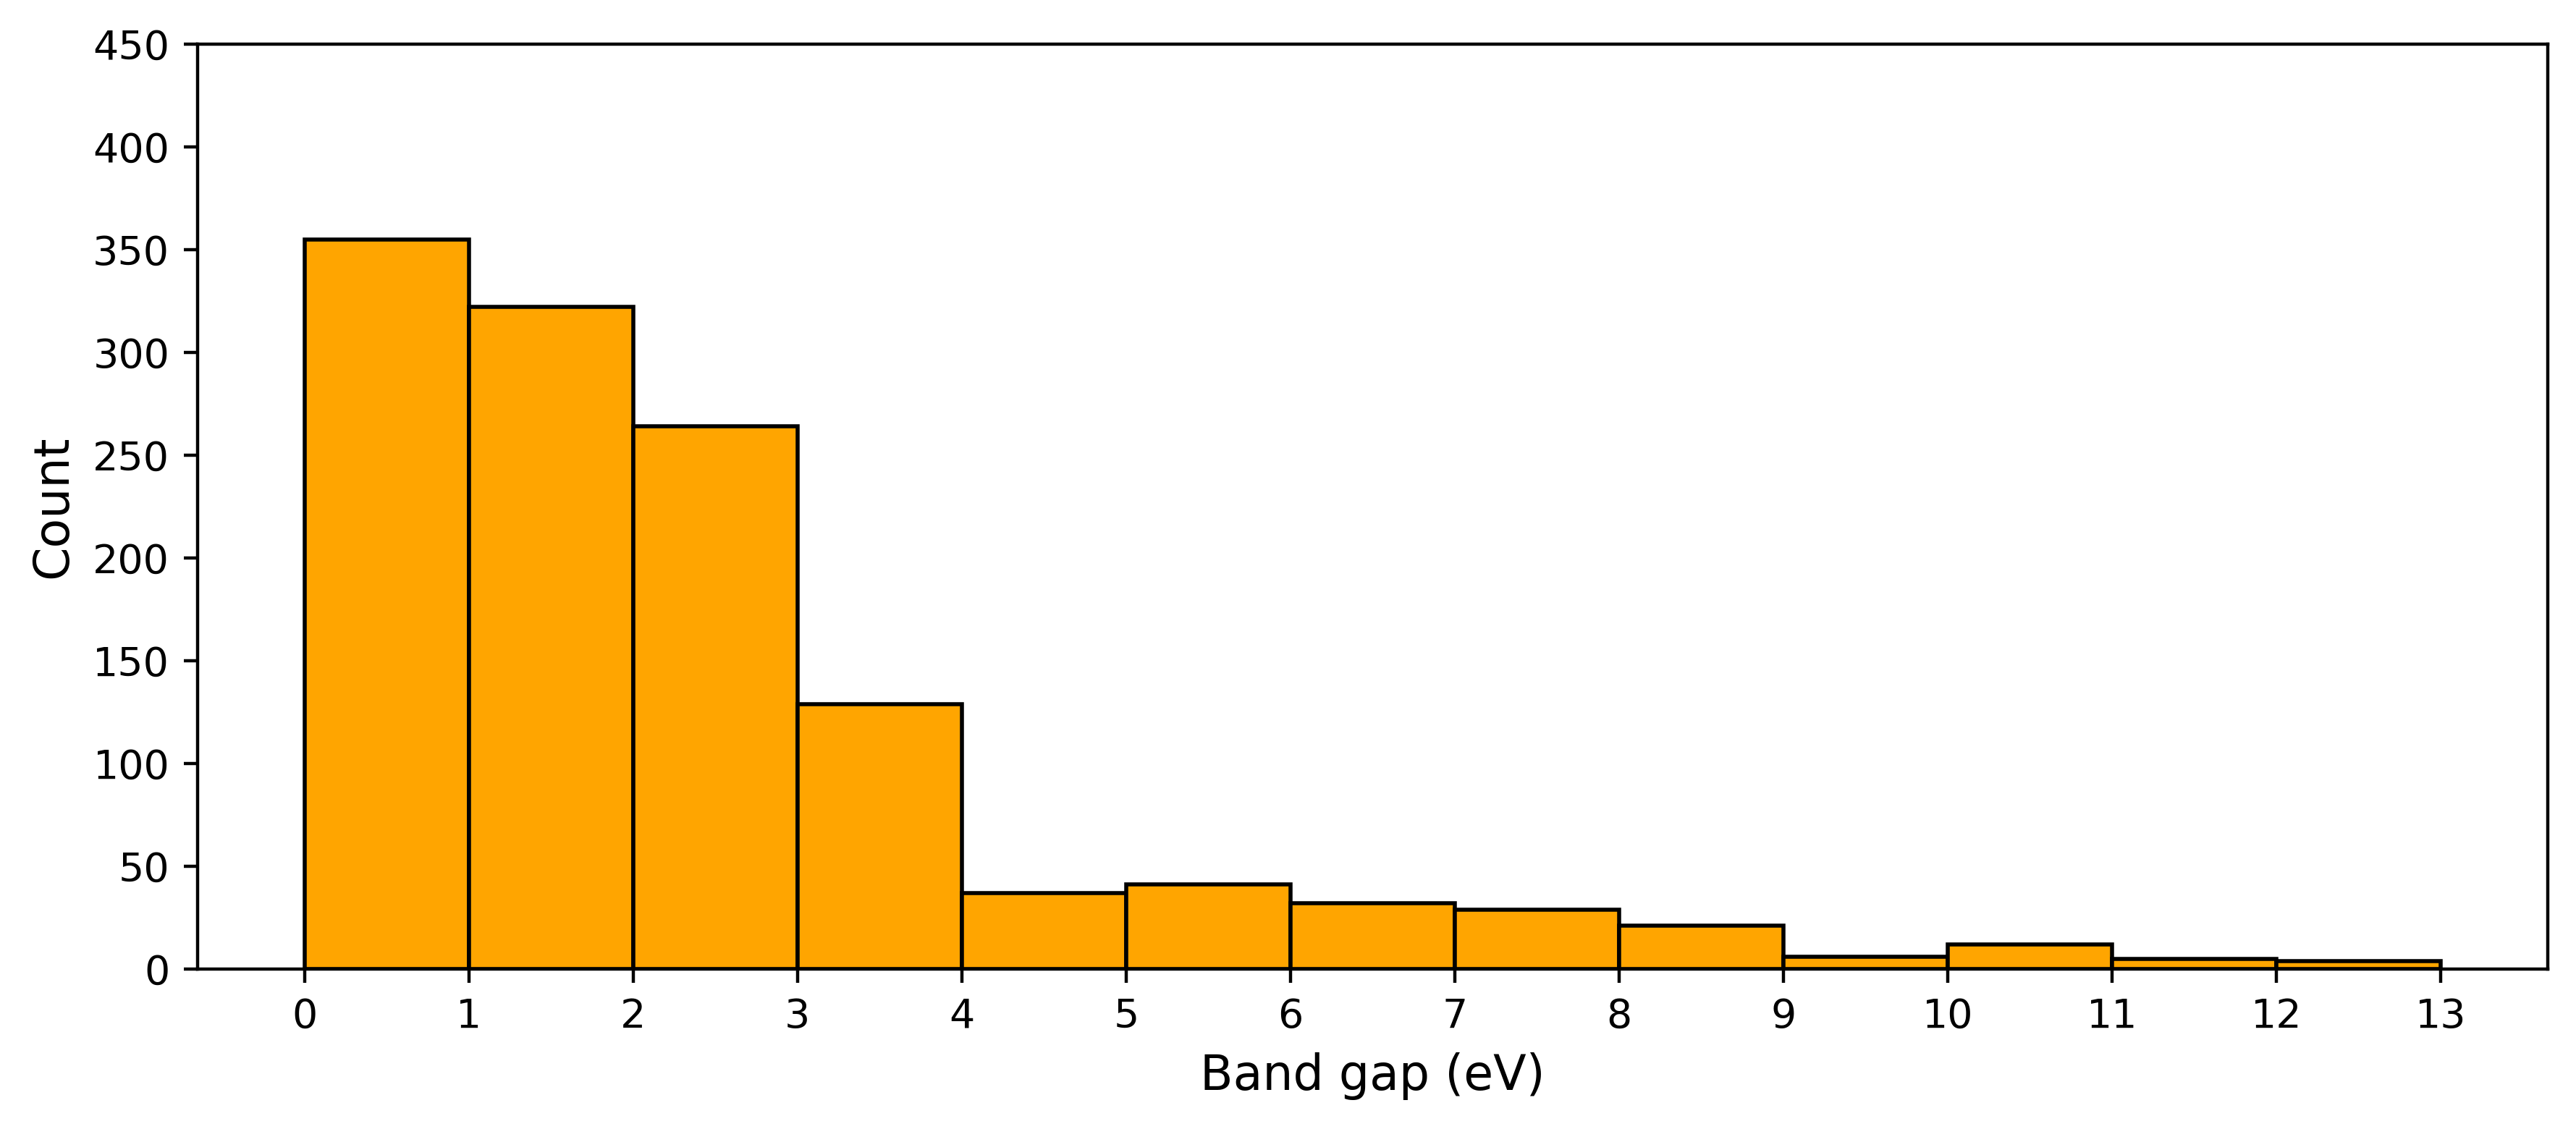

In [448]:
def histogram_plot(data):
    fig1,ax1 = plt.subplots(figsize=(9,4), dpi=400)
    ax1.hist(data,bins=np.arange(0, 14, 1),density=0,color='orange',edgecolor='black', lw=1) #density=1 gives % counts 
    ax1.set_xticks(np.arange(0, 14.0, 1.0))
    ax1.set_yticks(np.arange(0,451,50))
    ax1.set_xlabel('Band gap (eV)', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    plt.show()
    #plt.title('Band Gap Counts For Citrination')

histogram_plot(mastml_df_filtered["Band gap"].astype("float"))

In [64]:
# parse out individual elements for each formula using pymatgen's composition parser
element_list = list()
for idx in mastml_df_clean.index:
    element_list.extend(pymatgen.core.composition.Composition(mastml_df_clean["Chemical formula"][idx]).elements)

In [65]:
# setup a counter to count each element
temp_counter = Counter(element_list)
element_tuples = list(zip(list(temp_counter.keys()),list(temp_counter.values())))
element_df = pd.DataFrame(element_tuples,columns=["Element","Count"])
element_df_sorted = element_df.sort_values(by=["Count"],ascending=False)

In [66]:
element_df_sorted

Element  Count
1        O     73
2        S     56
3       Se     51
4       Te     48
13      Sb     42
10      As     40
21      Si     25
7        I     24
12       P     20
17      Bi     19
5       Br     16
23      Cd     16
36      Ge     15
11       B     14
22      Sn     13
8        N     13
6       Cl     13
20      Pb     13
72      Zn     12
40      In     12
46      Mn     12
33      Fe     11
34      Ga     11
15       F     11
19      Ca     10
45      Mg     10
59      Sm     10
38      Hg     10
65      Tl     10
29      Cu      9
..     ...    ...
55      Pt      5
48      Na      5
52      Os      5
50      Nd      5
14      Ba      5
56      Rb      5
41       K      5
30      Dy      5
60      Sr      4
69       W      4
71      Yb      4
57      Re      4
37      Hf      4
18       C      4
26      Co      4
51      Ni      4
47      Mo      3
24      Sc      3
49      Nb      3
35      Gd      3
62      Tb      2
67       U      2
25      Ce      2
70       Y      2
16      Be      2
39      Ho      2
63      Th      1
61      Ta      1
66      Tm      1
44      Lu      1

[74 rows x 2 columns]

In [67]:
data = mastml_df_clean['Chemical formula']
target = mastml_df_clean['Band gap']

In [ ]:
feature_types = ['composition_avg','max', 'min', 'difference']
#feature_types = ['composition_avg', 'arithmetic_avg']
#feature_types = ['difference','max', 'min']
#feature_types = ['composition_avg']

In [68]:
### MASTML ELEMENTAL FEATURE GENERATOR
# Using the list of compounds, this library generates around 80 different elemental features up to 5 types
## See MAGPIE for an updated version

################### FEATURE DATA
   # .. [1] A. M. Deml, R. O’Hayre, C. Wolverton, and V. Stevanović,
   # "Predicting density functional theory total energies and enthalpies of
   # formation of metal-nonmetal compounds by linear regression," Physical
   # Review B, vol. 93, no. 8, Feb. 2016.
    
#https://bitbucket.org/wolverton/magpie/src/master/
#https://github.com/ramv2/magpie_python/tree/ba01048e5b09b6da74b3d0a5a455844c89c9782c/lookup-data/ 

X, y = ElementalFeatureGenerator(composition_df=data,
                                feature_types=feature_types,
                                remove_constant_columns = False).evaluate(X=data, y=target, savepath=savepath, make_new_dir=False)


Dropping 4/352 generated columns due to missing values


In [98]:
##Save features into csv or xlsx

AllData = pd.concat([X, y],axis=1)
AllData.head()
#AllData.to_excel(savepath+'/AllData'+'.xlsx')
AllData.to_csv(savepath+'/AllData-Citrination-CDMM'+'.csv')

In [ ]:
# or import an existing data file
data_file = 'AllData.csv'
generated_features = pd.read_csv(data_file)
X = generated_features.drop['Chemical formula','Band gap']
y = generated_features['Band gap']

In [69]:
# Visualize the feature data set that used to train ML model(s)
X

Chemical formula  AtomicNumber_composition_average  \
0               Ag2O                         34.000000   
1               Ag2S                         36.666667   
2              Ag2Se                         42.666667   
3              Ag2Te                         48.666667   
4               AgBr                         41.000000   
5               AgCl                         32.000000   
6                AgI                         50.000000   
7               AgN3                         17.000000   
8               AgTe                         49.500000   
9              Al2O3                         10.000000   
10              AlAs                         23.000000   
11               AlB                          9.000000   
12               AlN                         10.000000   
13               AlP                         14.000000   
14              AlSb                         32.000000   
15                As                         33.000000   
16             As2O3                         18.000000   
17             As2S3                         22.800000   
18             As2S5                         20.857143   
19             As2S6                         20.250000   
20            As2Se3                         33.600000   
21            As2Te3                         44.400000   
22             As4S4                         24.500000   
23             AsBr3                         34.500000   
24              AsI3                         48.000000   
25              AsSe                         33.500000   
26              AsTe                         42.500000   
27                 B                          5.000000   
28              B2O3                          6.800000   
29               BAs                         19.000000   
..               ...                               ...   
394              VO2                         13.000000   
395              WO3                         24.500000   
396              WS2                         35.333333   
397             WSe2                         47.333333   
398             WTe2                         59.333333   
399             Y2O3                         20.400000   
400               YN                         23.000000   
401            Yb2O3                         32.800000   
402             YbAs                         51.500000   
403              YbS                         43.000000   
404             YbSb                         60.500000   
405           Zn3As2                         31.200000   
406            Zn3P2                         24.000000   
407           Zn3Sb2                         38.400000   
408           Zn4Sb3                         39.000000   
409            ZnAs2                         32.000000   
410             ZnI2                         45.333333   
411              ZnO                         19.000000   
412             ZnP2                         20.000000   
413              ZnS                         23.000000   
414             ZnSb                         40.500000   
415             ZnSe                         32.000000   
416             ZnTe                         41.000000   
417             Zr3O                         32.000000   
418             Zr6O                         35.428571   
419             ZrO2                         18.666667   
420             ZrS2                         24.000000   
421             ZrS3                         22.000000   
422            ZrSe2                         36.000000   
423            ZrSe3                         35.500000   

     AtomicNumber_difference  AtomicNumber_max_value  AtomicNumber_min_value  \
0                       39.0                    47.0                     8.0   
1                       31.0                    47.0                    16.0   
2                       13.0                    47.0                    34.0   
3                        5.0                    52.0                    47.0   
4      

In [73]:
# Visualize the target data set, actual values that about to be predicted.
y

0      1.430333
1      1.032500
2      0.122000
3      0.266714
4      2.979273
5      3.430444
6      2.869500
7      3.670000
8      0.850000
9      8.493333
10     2.258545
11     0.686667
12     5.855000
13     2.507500
14     1.764500
15     0.697000
16     4.500000
17     2.386909
18     2.330000
19     2.350000
20     1.690000
21     0.780000
22     2.400000
23     2.600000
24     2.415000
25     1.215000
26     0.740000
27     1.300000
28     4.900000
29     1.460000
         ...   
394    0.400000
395    2.800000
396    0.450000
397    1.465000
398    0.062500
399    5.600000
400    1.900000
401    2.990000
402    1.020000
403    0.253000
404    1.000000
405    0.766667
406    1.150000
407    0.210000
408    1.200000
409    1.043333
410    4.530000
411    3.354600
412    2.030000
413    3.767714
414    0.680062
415    2.764833
416    2.303000
417    0.200000
418    0.180000
419    2.775000
420    1.760000
421    2.225000
422    2.000000
423    1.250000
Name: Band gap, Length: 

In [418]:
# This code block is for manually-filtering the features - bypass feature selector below
selecting_columns = ['AtomicNumber', 'AtomicRadii', 'AtomicWeight', 'Electronegativity',  
                     'Group', 'MendeleevNumber', 'Period', 'Polarizability', 'ThermalConductivity', 'valence', 'ElectronAffinity']

#selecting_columns = ['BoilingT', 'HeatFusion','ElectronAffinity', 'HeatVaporization', 'MeltingT', 'SpecificHeatCapacity', 'Density', 'FirstIonizationEnergy', 'CovalentRadii', 'CovalentRadius', 'IonicRadii']

selected_features = []

for column in selecting_columns:

    #selected_features.append(column+'_composition_average')
    #selected_features.append(column+'_arithmetic_avg)
    selected_features.append(column+'_max_value')
    selected_features.append(column+'_difference')
    selected_features.append(column+'_min_value')

print(selected_features)

['AtomicNumber_max_value', 'AtomicNumber_difference', 'AtomicNumber_min_value', 'AtomicRadii_max_value', 'AtomicRadii_difference', 'AtomicRadii_min_value', 'AtomicWeight_max_value', 'AtomicWeight_difference', 'AtomicWeight_min_value', 'Electronegativity_max_value', 'Electronegativity_difference', 'Electronegativity_min_value', 'Group_max_value', 'Group_difference', 'Group_min_value', 'MendeleevNumber_max_value', 'MendeleevNumber_difference', 'MendeleevNumber_min_value', 'Period_max_value', 'Period_difference', 'Period_min_value', 'Polarizability_max_value', 'Polarizability_difference', 'Polarizability_min_value', 'ThermalConductivity_max_value', 'ThermalConductivity_difference', 'ThermalConductivity_min_value', 'valence_max_value', 'valence_difference', 'valence_min_value', 'ElectronAffinity_max_value', 'ElectronAffinity_difference', 'ElectronAffinity_min_value']


In [241]:
#pd.set_option('display.max_columns', 100)

In [74]:
## Split features into three dataframes
target_df = pd.DataFrame([X["Chemical formula"],y]).T
features_df = X.drop(columns=['Chemical formula'])
# Split the chemical formulas from the features data set.
X_extra = pd.DataFrame(target_df['Chemical formula'])

In [76]:
features_df.head()

AtomicNumber_composition_average  AtomicNumber_difference  \
0                         34.000000                     39.0   
1                         36.666667                     31.0   
2                         42.666667                     13.0   
3                         48.666667                      5.0   
4                         41.000000                     12.0   

   AtomicNumber_max_value  AtomicNumber_min_value  \
0                    47.0                     8.0   
1                    47.0                    16.0   
2                    47.0                    34.0   
3                    52.0                    47.0   
4                    47.0                    35.0   

   AtomicRadii_composition_average  AtomicRadii_difference  \
0                         1.206000                   0.714   
1                         1.386000                   0.174   
2                         1.429333                   0.044   
3                         1.496000                   0.156   
4                         1.292000                   0.304   

   AtomicRadii_max_value  AtomicRadii_min_value  \
0                  1.444                  0.730   
1                  1.444                  1.270   
2                  1.444                  1.400   
3                  1.600                  1.444   
4                  1.444                  1.140   

   AtomicVolume_composition_average  AtomicVolume_difference  ...  \
0                       6208.782821             18575.121519  ...   
1                         20.439281                10.090898  ...   
2                         20.453367                10.133157  ...   
3                         22.702662                16.881041  ...   
4                         29.801737                25.452177  ...   

   n_ws^third_max_value  n_ws^third_min_value  phi_composition_average  \
0                  1.36                  1.36                    2.900   
1                  1.36                  1.36                    2.900   
2                  1.36                  1.36                    2.900   
3                  1.36                  1.36                    2.900   
4                  1.36                  1.36                    2.175   

   phi_difference  phi_max_value  phi_min_value  valence_composition_average  \
0             0.0           4.35           4.35                     2.000000   
1             0.0           4.35           4.35                     3.333333   
2             0.0           4.35           4.35                     3.333333   
3             0.0           4.35           4.35                     3.333333   
4             0.0           4.35           4.35                     4.500000   

   valence_difference  valence_max_value  valence_min_value  
0                 0.0                2.0                2.0  
1                 4.0                6.0                2.0  
2                 4.0                6.0                2.0  
3                 4.0                6.0                2.0  
4                 5.0                7.0                2.0  

[5 rows x 348 columns]

In [75]:
target_df.head()

Chemical formula  Band gap
0             Ag2O   1.43033
1             Ag2S    1.0325
2            Ag2Se     0.122
3            Ag2Te  0.266714
4             AgBr   2.97927

In [77]:
X_extra

Chemical formula
0               Ag2O
1               Ag2S
2              Ag2Se
3              Ag2Te
4               AgBr
5               AgCl
6                AgI
7               AgN3
8               AgTe
9              Al2O3
10              AlAs
11               AlB
12               AlN
13               AlP
14              AlSb
15                As
16             As2O3
17             As2S3
18             As2S5
19             As2S6
20            As2Se3
21            As2Te3
22             As4S4
23             AsBr3
24              AsI3
25              AsSe
26              AsTe
27                 B
28              B2O3
29               BAs
..               ...
394              VO2
395              WO3
396              WS2
397             WSe2
398             WTe2
399             Y2O3
400               YN
401            Yb2O3
402             YbAs
403              YbS
404             YbSb
405           Zn3As2
406            Zn3P2
407           Zn3Sb2
408           Zn4Sb3
409            ZnAs2
410             ZnI2
411              ZnO
412             ZnP2
413              ZnS
414             ZnSb
415             ZnSe
416             ZnTe
417             Zr3O
418             Zr6O
419             ZrO2
420             ZrS2
421             ZrS3
422            ZrSe2
423            ZrSe3

[424 rows x 1 columns]

## Automated Feature Selection

In [352]:
# Define the models that select features
random_forest_reg = sklearn.ensemble.RandomForestRegressor(random_state=seed, criterion='mse', n_estimators=500, bootstrap=True)
mlp_reg = SklearnModel(model='MLPRegressor', random_state=seed)

preprocessor = SklearnPreprocessor(preprocessor='StandardScaler', as_frame=True)

In [ ]:
def manageCorrelation(feat_data):
    # This block is used to find and to drop highly-correlated features in a given feature dataframe 
    corr_matrix = feat_data.corr(method='pearson').abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    features_df_filt_lowcorr = feat_data.drop(to_drop, axis=1) # drop highly-correlated features
    return features_df_filt_lowcorr

In [ ]:
def trainRegressor(regressor=random_forest_reg, X_data=features_df_filt_lowcorr, y_data=y):
    Xcopy = preprocessor.evaluate(X=X_data, =y_data)
    X_train, X_test, y_train, y_test = train_test_split(Xcopy, y, test_size=test_fraction, shuffle=True, random_state=seed)
    sel_model = regressor.fit(X_train, y_train) # fit the selector model
    y_pred = sel_model.predict(X_test)
    return y_pred

In [615]:
def trainModel(good_list_=[], features_df = features_df, n_best_features=3):
    score_list = []
    mae_list = []
    rmse_list = []
    r2_list = []
    # when no feature list is specified, 
    # change n_best_features to specify the number of features will be selected by the if-block below
    
    if(len(good_list_)<1): ## if initial features are not specified, find it automatically
        init_selector = random_forest_reg.fit(features_df,y)
        feat_importances = pd.Series(random_forest_reg.feature_importances_, index=features_df.columns)
        best3features = list(feat_importances.nlargest(n_best_features).keys())
        good_list_=best3features
    
    feat_data = pd.DataFrame(features_df, columns=good_list_)

    features_df_filt_lowcorr = manageCorrelation(feat_data) # new version
    y_pred = trainRegressor(regressor=random_forest_reg, X_data=features_df_filt_lowcorr, y_data=y)
    
    #scores = sklearn.model_selection.cross_validate(sel_model, Xcopy, y, cv=5, 
    #                                                scoring=['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'])
    
    #r2_score = (scores['test_r2']).max()
    #mae_score = (scores['test_neg_mean_absolute_error']).max()
    #rmse_score =(scores['test_neg_root_mean_squared_error']).max()
    
    mae_score = sklearn.metrics.mean_absolute_error(y_test, y_pred)
    rmse_score = sklearn.metrics.mean_squared_error(y_test, y_pred, squared=False)
    r2_score = sklearn.metrics.r2_score(y_test, y_pred)
    r2adj = mastml.metrics.r2_score_adjusted(y_test, y_pred, n_features=len(good_list_))
    #num_obs = len(X_test)
    #r2adj = 1-(1-r2_score)*(num_obs-1)/(num_obs-len(good_list_)-1)

    r2_list.append(r2_score)
    score_list.append(r2adj)
    mae_list.append(mae_score)
    rmse_list.append(rmse_score)
    return score_list, r2_list, mae_list, rmse_list, sel_model, good_list_

#score_list, r2_list, mae_list, rmse_list, sel_model = trainModel(test_comp2)
#print(score_list, r2_list, mae_list, rmse_list) #mae, comp2
#scores = sklearn.model_selection.cross_validate(sel_model, Xcopy, y, cv=5, scoring=['r2', 'neg_mean_absolute_error','neg_root_mean_squared_error'])
#scores

In [262]:
# Obtained from StackOverflow
# https://www. ...

def metricsPrint(test_df, pred_df, outputDf):
    r2_score_adj_ = (1 - (1-r2_score)*(len(outputDf)-1)/(len(outputDf)-len(Xcopy.columns)-1))
    print('Mean Absolute Error (MAE):', "%.3f"%sklearn.metrics.mean_absolute_error(test_df, pred_df))
    print('Mean Squared Error (MSE):', "%.3f"%sklearn.metrics.mean_squared_error(test_df, pred_df))
    print('Root Mean Squared Error (RMSE):', "%.3f"%sklearn.metrics.mean_squared_error(test_df, pred_df, squared=False))
    print('Mean Absolute Percentage Error (MAPE):', "%.3f"%sklearn.metrics.mean_absolute_percentage_error(test_df, pred_df))
    print('Explained Variance Score:', "%.3f"%sklearn.metrics.explained_variance_score(test_df, pred_df))
    print('Max Error:', "%.3f"%sklearn.metrics.max_error(test_df, pred_df))
    print('Mean Squared Log Error:', "%.3f"%sklearn.metrics.mean_squared_log_error(test_df, pred_df))
    print('Median Absolute Error:', "%.3f"%sklearn.metrics.median_absolute_error(test_df, pred_df))
    print('R^2:', "%.3f"%(sklearn.metrics.r2_score(test_df, pred_df)))
    print('R^2_ADJ :', "%.3f"%(r2_score_adj_)) # %%% 
    print('R^2_FPE :',"%.3f"%(((len(outputDf)+len(Xcopy.columns))*r2_score_adj_-len(Xcopy.columns))/(len(outputDf)+1)))
    print('Mean Poisson Deviance:', "%.3f"%sklearn.metrics.mean_poisson_deviance(test_df, pred_df))
    print('Mean Gamma Deviance:', "%.3f"%sklearn.metrics.mean_gamma_deviance(test_df, pred_df))
    
#metricsPrint(y_test,y_pred, X_test)

In [140]:
def shuffleList(featureList, randomize=True):
    # Manages the shuffling of a given list
    # When randomize is false, shuffles the list according to the seed
    if randomize==True:
        random.seed()
    else:
        random.seed(seed)
    return random.sample(list(featureList), len(featureList))
#list_ = shuffleList(testList, randomize=False)

In [613]:
#random.seed(seed) # Decomment to obtain the same feature list.
randomize=False # True to get different results, False for consistency
# If results are not good enough, disable/comment the code and
# use feature selector to create more than 1 list.

tic = time.perf_counter() # start timer

score_list, r2_list, mae_list, rmse_list, sel_model, good_list = trainModel(test_features)

toc1 = time.perf_counter() # stop timer1

print(f"Initial features found in {toc1 - tic:0.3f} seconds.")
print('initial features are: '+ good_list[0]+' ,'+good_list[1]+' ,'+good_list[2])

features_2b_tried = features_df[features_df.columns.difference(good_list)] ## Features to be tested
features_2b_tried_list = features_2b_tried.columns

#randomization here is managed by random.seed(any_integer)
#shuffled_features = random.sample(list(features_2b_tried_list),len(features_2b_tried_list)) #old (random.Random().sample(...))
shuffled_features = shuffleList(features_2b_tried_list, randomize=randomize) # new version of shuffling

i=0
# this for-loop search for good features that improve metric performance.
for feature in shuffled_features:
    good_list.append(feature) # Feature to be tested
    feat_data = pd.DataFrame(features_df, columns=good_list)
    
    ## Correlation
    features_df_filt_lowcorr = manageCorrelation(feat_data) # new version
    y_pred = trainRegressor(regressor=random_forest_reg, X_data=features_df_filt_lowcorr, y_data=y)
    ## Preprocessing and #TrainTestSplit 
    Xcopy = preprocessor.evaluate(X=features_df_filt_lowcorr, y=y)
    X_train, X_test, y_train, y_test = train_test_split(Xcopy, y, test_size=test_fraction, shuffle=True, random_state=seed)
    sel_model = random_forest_reg.fit(X_train, y_train) # fit the selector model
    y_pred = sel_model.predict(X_test)
    
    ##Metrics
    mae_score = sklearn.metrics.mean_absolute_error(y_test, y_pred)
    rmse_score = sklearn.metrics.mean_squared_error(y_test, y_pred, squared=False)
    r2_score = sklearn.metrics.r2_score(y_test, y_pred)
    r2adj = mastml.metrics.r2_score_adjusted(y_test, y_pred, n_features=len(good_list))
    
    #positive mae rmse
    if(r2adj<max(score_list) or r2_score<max(r2_list) or mae_score>max(mae_list) or rmse_score>max(rmse_list)): # best results
        good_list = good_list[:-1]
    if(feature==good_list[-1]):
        print('New score: '+"%.3f"%r2adj+'/'+"%.3f"%r2_score+' :: - MAE: '+"%.3f"%mae_score+' - RMSE: '+"%.3f"%rmse_score+', Adding: '+good_list[-1])
    score_list.append(r2adj)
    r2_list.append(r2_score)
    mae_list.append(mae_score)
    rmse_list.append(rmse_score)
    i=i+1

toc2 = time.perf_counter() # stop timer2

print(f"Feature selection completed in {toc2 - tic:0.3f} seconds.")

Initial features found in 1.142 seconds.
initial features are: valence_difference ,ElectronAffinity_difference ,ElectronAffinity_max_value
New score: 0.580/0.607 :: - MAE: 0.866 - RMSE: 1.454, Adding: BCCenergy_pa_composition_average
New score: 0.582/0.615 :: - MAE: 0.866 - RMSE: 1.438, Adding: IsHexagonal_min_value
New score: 0.588/0.628 :: - MAE: 0.862 - RMSE: 1.415, Adding: IsBCC_max_value
New score: 0.628/0.669 :: - MAE: 0.814 - RMSE: 1.334, Adding: SpecificHeatCapacity_min_value
New score: 0.678/0.719 :: - MAE: 0.720 - RMSE: 1.229, Adding: MeltingT_min_value
New score: 0.696/0.740 :: - MAE: 0.753 - RMSE: 1.183, Adding: MiracleRadius_difference
New score: 0.713/0.758 :: - MAE: 0.734 - RMSE: 1.140, Adding: Density_max_value
New score: 0.714/0.764 :: - MAE: 0.718 - RMSE: 1.126, Adding: NdUnfilled_max_value
New score: 0.717/0.771 :: - MAE: 0.715 - RMSE: 1.109, Adding: NpUnfilled_min_value
New score: 0.719/0.777 :: - MAE: 0.678 - RMSE: 1.095, Adding: HeatFusion_difference
New score: 0.

## HYPERPARAMETER OPTIMIZATION

In [215]:
kfold = RepeatedKFold(n_splits=5,
                      random_state=seed,
                      n_repeats=5)
print(kfold)

In [104]:
# Generate train/test split by reserving 15% of data as test set
test_fraction = 0.15

X_train, X_test, y_train, y_test = train_test_split(Xcopy, y, test_size=test_fraction, shuffle=True, random_state=seed)
#y_Formula = target_df["Chemical formula"]
#X_train, X_test, y_form, y_form = train_test_split(Xcopy, y_Formula, test_size=test_fraction, shuffle=True,random_state=seed)

In [386]:
#model_dt_def = RandomForestRegressor(random_state=seed,n_estimators=1,bootstrap=False).fit(X_train,y_train) # fit the decision tree model
model_rf_def = SklearnModel(model='RandomForestRegressor',random_state=seed,criterion='mse', n_estimators=500,bootstrap=False).fit(X_train,y_train)
#model_nn_def = SklearnModel(model='MLPRegressor', random_state=seed, max_iter=500).fit(X_train,y_train)
#model_gpr_def = SklearnModel(model='GaussianProcessRegressor', kernel='ConstantKernel*RBF', n_restarts_optimizer=10).fit(X_train,y_train)
#print('Model training complete.')

##print('R2:',"%.3f"%metric_scores['r2_score'], ', MAE:',"%.3f"%metric_scores['mean_absolute_error'], ', RMSE:',"%.3f"%metric_scores['root_mean_squared_error'])

/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [109]:
#print('Default model uses the following hyperparameters:\n') # print default hyperparameters used
pprint(model_rf_def.get_params())

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': True,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 1500,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 12345123,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}


In [430]:
### Parameter dictionaries for different models ###

number_of_trees = [50,100,500]

opt_dict_rf = {'n_estimators':number_of_trees,'bootstrap':['True']}

opt_dict_krr = {
            'alpha': np.arange(1,2,0.1),
            'kernel':['linear','rbf'] }

opt_dict_nn = {'alpha':[0.0001,0.001,0.01,0.0005],'max_iter':[1500,2000],'warm_start':[False,True],'epsilon':[1.1,1.2,1.3,1.4,1.5],
           'learning_rate_init':[0.001,0.01,0.1], 'hidden_layer_sizes':[(170,), (70,), (50,), (20,)]}

In [431]:
CV = GridSearchCV(model_rf_def, # 1. the model whose hyperparamter is being optimized right now
                  param_grid=opt_dict,   # 2. a dictionary of values that we want the grid search to use
                  cv=5,#kfold,
                  #scoring='accuracy')# 4. k-fold cross-validation strategy is used to define training and validation splits (note this is separate from test splits) to be used for each grid point
                  return_train_score=True,
                  scoring=['neg_mean_squared_error','r2','neg_mean_absolute_error'], # 5. the performance metrics to be reported at each grid point specified in opt_dict
                  refit='neg_mean_squared_error')

# perform grid search
tic = time.perf_counter() # start timer

CV = CV.fit(X_train,y_train)

toc = time.perf_counter() # stop timer

# print results
print(f"Grid search completed in {toc - tic:0.3f} seconds.")
print(CV.best_params_)
#print()

Grid search completed in 5.071 seconds.
{'alpha': 1.0, 'kernel': 'rbf'}


In [217]:
### RF
#{'bootstrap': 'True', 'criterion': 'mae', 'n_estimators': 100}
best_dt = CV.best_estimator_
best_dt

RandomForestRegressor(bootstrap='True', n_estimators=500, random_state=12345123)

In [43]:
# Data can be loaded with the following way, after using MASTML Preprocessor that saves the dataframe:
Xcopy = pd.read_excel(savepath+'/data_preprocessed_.xlsx', index_col=[0])
Xcopy

valence_difference  ElectronAffinity_difference  \
2               0.771348                    -0.265523   
3               0.771348                    -0.339417   
5               1.498442                     0.941406   
6              -2.137029                    -1.145480   
8               0.771348                    -0.342665   
9               0.771348                    -0.279057   
10              0.771348                    -0.352951   
12              0.771348                     0.316423   
13              0.771348                     0.242529   
16              0.771348                    -0.008385   
17              1.498442                     0.941406   
18              0.771348                     0.316423   
19              0.771348                     0.242529   
22              0.771348                    -0.265523   
23              0.771348                    -0.352951   
25             -1.409935                    -0.053316   
26              0.771348                     0.749499   
27              0.771348                     0.675605   
28              0.771348                     0.610508   
29              0.771348                     0.316423   
30              0.771348                     0.242529   
31              0.771348                     0.177432   
34              0.771348                    -0.130187   
35              0.771348                    -0.204081   
36              1.498442                     1.337941   
37              1.498442                     1.665455   
38             -1.409935                     1.383955   
39              0.771348                     0.959811   
40              0.771348                     0.894715   
41             -1.409935                     0.163222   
...                  ...                          ...   
3511            0.044253                    -1.353898   
3512            0.044253                    -1.353898   
3517            0.771348                     0.892143   
3519            0.044253                    -0.771952   
3520            0.044253                     0.364873   
3521            0.044253                    -0.700224   
3522            1.498442                    -1.353898   
3523            0.771348                     0.966037   
3524            0.771348                     0.892143   
3525            0.771348                     0.827046   
3527           -2.137029                    -1.353898   
3528            0.771348                    -1.353898   
3529            0.044253                    -1.353898   
3531            0.771348                    -1.353898   
3532            0.044253                    -0.587895   
3533            0.044253                    -0.516166   
3535            0.044253                    -0.758418   
3536           -0.682841                    -1.081872   
3537            0.044253                    -0.686690   
3538            0.044253                    -1.083225   
3539            1.498442                    -1.353898   
3540            0.771348                    -1.353898   
3557           -0.682841                    -0.120984   
3579           -2.137029                    -0.375417   
3594           -0.682841                    -0.528347   
3596           -0.682841                    -0.120984   
3602           -0.682841                     0.681831   
3603           -0.682841                     0.681831   
3607           -0.682841                     0.607937   
3608           -0.682841                     0.607937   

      ElectronAffinity_max_value  Polarizability_min_value  \
2                       0.432024                 -0.004097   
3                       0.380445                  0.344149   
5                       1.328325                  0.846504   
6                      -0.128354                 -0.843891   
8                       0.432024                 -0.004097   
9                       0.432024                 -0.004097   
10                      0.380445     

## MASTML Model Training

In [67]:
hyperopt = GridSearch(param_names='alpha',
                     param_values='-5 5 100 log float',
                     scoring='root_mean_squared_error')
# for KRR
hyperopt2 = RandomizedSearch(param_names='alpha ; gamma',
                            param_values='uniform ; uniform',
                            scoring='root_mean_squared_error',
                            n_iter=100)
# for MLP
hyperopt3 = GridSearch(param_names='hidden_layer_sizes',
                     param_values='(20,) (20,10) (10,5) (10,) (20,10,5) tup',
                     scoring='root_mean_squared_error')

In [406]:
#n_est = CV.best_params_['n_estimators']
#bootst = CV.best_params_['bootstrap']
model_lin = SklearnModel(model='LinearRegression')
model_rf = SklearnModel(model='RandomForestRegressor', random_state=seed)
opt_model_RF = SklearnModel(model='RandomForestRegressor', n_estimators=500, bootstrap=True,criterion='mse', random_state=seed)
opt_model_nn = SklearnModel(model='MLPRegressor', hidden_layer_sizes=(70,),max_iter=500, random_state=seed)
opt_model_nn_170 = SklearnModel(model='MLPRegressor', hidden_layer_sizes=(170,),max_iter=500, random_state=seed)
opt_model_nn_20 = SklearnModel(model='MLPRegressor', hidden_layer_sizes=(20,),max_iter=1000, random_state=seed)
opt_model_nn_20_t = SklearnModel(model='MLPRegressor',activation='tanh', hidden_layer_sizes=(20,),max_iter=1500, random_state=seed)
#{'activation': 'tanh', 'early_stopping': False, 'hidden_layer_sizes': (20,)}
#model_nn = SklearnModel(model='MLPRegressor', hidden_layer_sizes=(20, 10))

#models = [model_krr, model_rf]
#metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error','r2_score_adjusted', 'rmse_over_stdev']
metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']


In [70]:
comp2 = ['valence_difference',
 'ElectronAffinity_difference',
 'ElectronAffinity_max_value',
 'Polarizability_min_value',
 'SecondIonizationEnergy_max_value',
 'AtomicRadii_min_value',
 'HeatFusion_max_value',
 'IsRareEarth_composition_average',
 'GSbandgap_max_value',
 'ThirdIonizationEnergy_composition_average',
 'n_ws^third_composition_average',
 'NfValence_composition_average',
 'GSenergy_pa_max_value',
 'IsMetalloid_composition_average',
 'NValance_composition_average',
 'BCCfermi_min_value',
 'NpUnfilled_composition_average',
 'BCCfermi_composition_average',
 'IonicRadii_max_value',
 'NpValence_composition_average',
 'NValance_min_value',
 'SpaceGroupNumber_difference',
 'NdUnfilled_max_value']

In [79]:
preprocessor = SklearnPreprocessor(preprocessor='StandardScaler', as_frame=True)
#prep2 = SklearnPreprocessor(preprocessor='MinMaxScaler', as_frame=True)

# Split data kfold, defined by n_splits. used for cross-validation
splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=1, n_splits=5, random_state=seed)

In [433]:
splitter.evaluate(X=Xcopy, #or X=X[any_feature_list]
                  y=y, 
                  models=[opt_model_RF],
                  preprocessor=preprocessor,
                  metrics=metrics,
                  plots=['Error'],
                  #hyperopts=[hyperopt],
                  savepath=savepath,
                  X_extra=X_extra,
                  #nested_CV=True,
                  error_method='stdev_weak_learners', 
                  recalibrate_errors=True,
                  verbosity=3)

/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/mastml/plots.py:684: UserWarning: FixedFormatter should only be used together with FixedLocator
  axin.set_xticklabels(xlabels, fontsize=8, rotation=90)
/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/mastml/plots.py:685: UserWarning: FixedFormatter should only be used together with FixedLocator
  axin.set_yticklabels(ylabels, fontsize=8)
/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/mastml/plots.py:684: UserWarning: FixedFormatter should only be used together with FixedLocator
  axin.set_xticklabels(xlabels, fontsize=8, rotation=90)
/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/mastml/plots.py:685: UserWarning: FixedFormatter should only be used together with FixedLocator
  axin.set_yticklabels(ylabels, fontsize=8)
/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/mastml/plots.py:684: UserWarning: FixedFormatter should only be 

## SAVING RESULTS AND DISPLAYING STATISTICS
Code below is an error rate calculator which used for obtaining 'Error(%)'
\begin{equation}
  APE = \frac{|Actual-Predicted|}{|Actual|}*100
\end{equation}

In [6]:
def errorRateCal(y_test, y_prediction, absolute=True, percentile=True):
    errList = []
    for i in range(0,len(y_test)):
        #error = (((y_test.iloc[i])/(y_prediction[i])))*100
        #error = abs(1-((y_test.iloc[i])/(y_prediction[i])))*100
        #error = abs(1-((np.ravel(test_df)[i])/(np.ravel(pred_df)[i])))*100
        
        if absolute==False:
            error = (((np.ravel(y_test)[i])-(np.ravel(y_prediction)[i]))/(np.ravel(y_test)[i]))
        if absolute==True:
            error = (abs((np.ravel(y_test)[i])-(np.ravel(y_prediction)[i]))/abs(np.ravel(y_test)[i]))
        
        if percentile==True:
            error_rate = float("%.3f" % (error*100))
        if percentile==False:
            error_rate = float("%.3f" % (error))
        
        errList.append(error_rate)
    return errList

def errorCal(y_test, y_prediction, absolute=True): ## DEPRICATED
    errList = []
    for i in range(0,len(y_test)):
        #error = (((y_test.iloc[i])/(y_prediction[i])))*100
        #error = abs(1-((y_test.iloc[i])/(y_prediction[i])))*100
        #error = abs(1-((np.ravel(test_df)[i])/(np.ravel(pred_df)[i])))*100
        if absolute==False:
            error = (((np.ravel(y_test)[i])-(np.ravel(y_prediction)[i]))/(np.ravel(y_test)[i]))
        else:
            error = (abs((np.ravel(y_test)[i])-(np.ravel(y_prediction)[i]))/abs(np.ravel(y_test)[i]))
        error_rate = float("%.3f" % (error*100))
        errList.append(error_rate)
    return errList

In [434]:
### AUTOMATED FILE SAVER & PRINTER

save = False
rangeOf = [0.0,10.0] # show results that has error rate between 0% and 10%

## Create a list of trained model folders and then sort depending on time label
files = os.listdir('./'+savepath)
file_df = pd.DataFrame(columns=['Model','Val_Method','PreProcessor','Select','MM','DD','HH','mm','ss'])
#files.remove('folderName') ## use if folder content is not compatible

flist = []
pathList=[]
dateList =[]
df_list = []
for paths in files:
    if 'SklearnPreprocessor' in paths:
        pathList.append(paths)
sorted(pathList, key=lambda x: int(x.rsplit('_', 2)[-2]))

#pathList = pathList[-12:-9] # can be used to filter out some of the folders

for fname in pathList:
    folName = fname.split('_')
    file_df.loc[len(file_df.index)] = folName

file_df = file_df.sort_values(by=['MM','DD','HH','mm'], ascending=True)
    
for i in range(len(pathList)):
    outputDf = pd.DataFrame()
    new_folder = '/'+str(pathList[i])
    for splitNo in range(0,5):
        splitNo = str(splitNo)
        filePath = savepath+new_folder+'/split_'+splitNo
        test_df = pd.read_excel(filePath+'/y_test.xlsx', index_col = False) 
        pred_df = pd.read_excel(filePath+'/y_pred.xlsx', index_col = False)
        x_test_df = pd.read_excel(filePath+'/X_test.xlsx', index_col = False) 
        if 'KernelRidge' or 'SGDRegressor' in pathList[i]:
            err_df = pd.DataFrame(errorCalc(test_df, pred_df))
        else:
            err_df = pd.read_excel(filePath+'/model_errors_test.xlsx',index_col = False)
        formula_df = pd.read_excel(filePath+'/X_extra_test.xlsx', index_col = False)

        errorPercent = pd.DataFrame(errorRateCal(test_df, pred_df))

        #frames = [formula_df, test_df, pred_df, errorPercent]
        frames = [formula_df, test_df, pred_df, err_df, errorPercent]
        
        results_df = pd.concat(frames, axis=1).set_axis(['Formula','Band Gap','Predicted','Error','Error(%)'],axis=1, inplace=False)
        #results_df.to_csv(savepath+new_folder+'/MergedData'+splitNo+'.csv',index=False)

        #outputDf = outputDf.append(pd.read_csv(savepath+new_folder+'/MergedData'+splitNo+'.csv'), ignore_index=True)
        outputDf = outputDf.append(results_df, ignore_index=True)

        outputDf = outputDf.sort_values(by=["Band Gap"],ascending=True)
    
    df_list.append(outputDf) ## Gather all output dataframes in a single list
    
    if save == True:
        with pd.ExcelWriter(path+'/output_'+fileDescriptor+'.xlsx') as writer:
            #results_df.to_excel(writer,sheet_name='Split'+splitNo)
            outputDf.to_excel(writer, sheet_name='AllSplits')
        print('Data merged in '+savepath+new_folder+'/output_'+fileDescriptor+'.xlsx')
        
    #metric_scores = Metrics(metrics_list = metrics).evaluate(y_true = test_df, y_pred=pred_df) ## use defined metrics list
    metric_scores = Metrics(metrics_list =['r2_score','root_mean_squared_error','mean_absolute_error']).evaluate(y_true = test_df, y_pred=pred_df)
    errorCount = outputDf[abs(outputDf['Error(%)'])<10].count()
    ######################

    print('MODEL:', file_df['Model'].iloc[i]+'_'+file_df['HH'].iloc[i]+file_df['mm'].iloc[i]) #v2
    ##print('MODEL:', flist[i],' Date:', dateList[i])
    
    r2_score = metric_scores['r2_score']
    #r2_score_adj = metric_scores['r2_score_adjusted']
    ##r2_score_adj = (1 - (1-r2_score*100)*(len(outputDf)-1)/(len(outputDf)-len(Xcopy.columns)-1)) # normal
    #r2_score_adj = (1 - (1-r2_score*100)*(len(outputDf)-1)/(len(outputDf)-len(Xcopy.columns)-1)) # %ile
    #r2_fpe = ((len(outputDf)+len(Xcopy.columns))*r2_score_adj-len(Xcopy.columns))/(len(outputDf)+1)
    mae_score =metric_scores['mean_absolute_error']
    rmse_score=metric_scores['root_mean_squared_error']
    
    print('Number of Materials with Error Less Than ',rangeOf[1],'% is ', errorCount[1])
    print('Overall accuracy for ',len(outputDf),' compounds is ', "%.3f"%(errorCount[1]/len(outputDf)*100),'%')
    #print('R2:',"%.3f"%r2_score,'R2_adj:',"%.3f"%r2_score_adj, 'MAE:',"%.3f"%mae_score, ', RMSE:',"%.3f"%rmse_score)
    print('R2:',"%.3f"%r2_score,'MAE:',"%.3f"%mae_score, ', RMSE:',"%.3f"%rmse_score)
    print()
    
    #print(outputDf[(outputDf['Band Gap']<3) & (outputDf['Error(%)']<10)].count()[-1] ,'Predicted with low error between 0-3eV')
    #print(outputDf[(outputDf['Band Gap']>3) & (outputDf['Error(%)']<10)].count()[-1] ,'Predicted with low error between 3-12.6eV')

MODEL: RandomForestRegressor_1747
Number of Materials with Error Less Than  10.0 % is  102
Overall accuracy for  424  compounds is  24.057 %
R2: 0.868 MAE: 0.476 , RMSE: 0.608



In [156]:
assert False, "Breakpoint"

AssertionError: breakpoint

### Further Testing on Matminer Data set

In [246]:
#sel_model.estimators_
#sel_model.feature_importances_
best_DT = sel_model.estimators_[2]

In [241]:
pred_scores = sklearn.model_selection.cross_val_predict(best_dt, X_test, y_test, cv=5)
print(pred_scores, np.mean(pred_scores), np.std(pred_scores))

[1.49229829 1.92142117 0.96797029 4.63843116 0.77227048 1.99479009
 0.95748513 2.26557066 4.52887091 3.24603741 1.35142728 1.75931485
 1.24042448 1.0838145  3.15682248 5.06436164 1.62255127 2.25432362
 3.29952045 1.52153436 0.68318166 1.58022582 1.28017792 2.54392175
 2.25890216 1.58648482 1.01819202 1.24298345 2.64888107 1.16621335
 1.29349852 8.13860247 1.53230568 2.96796273 0.16337391 1.90837304
 2.36535643 1.02511928 2.61731435 0.6952343  0.59851189 1.62492878
 0.114934   0.84785668 1.49002825 2.18611781 2.04612769 2.03702236
 1.81971893 1.90694452 1.96640391 3.15485087 0.15648242 1.79826553
 1.40275214 2.36758977 1.06676462 3.06303766 2.02945112 2.73158713
 1.01205382 5.94166433 2.93624287 3.73480907] 2.060776428143601 1.3718341203492432


In [248]:
lin_reg = sklearn.linear_model.LinearRegression().fit(X_train,y_train)
lin_reg.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': True,
 'positive': False}

In [251]:
mae_score = sklearn.metrics.mean_absolute_error(y_test, preds)
rmse_score = sklearn.metrics.mean_squared_error(y_test, preds, squared=False)
r2_score = sklearn.metrics.r2_score(y_test, preds)
print(r2_score, mae_score,rmse_score)

0.41240695077560063 1.1911589596222032 1.7776120105272273


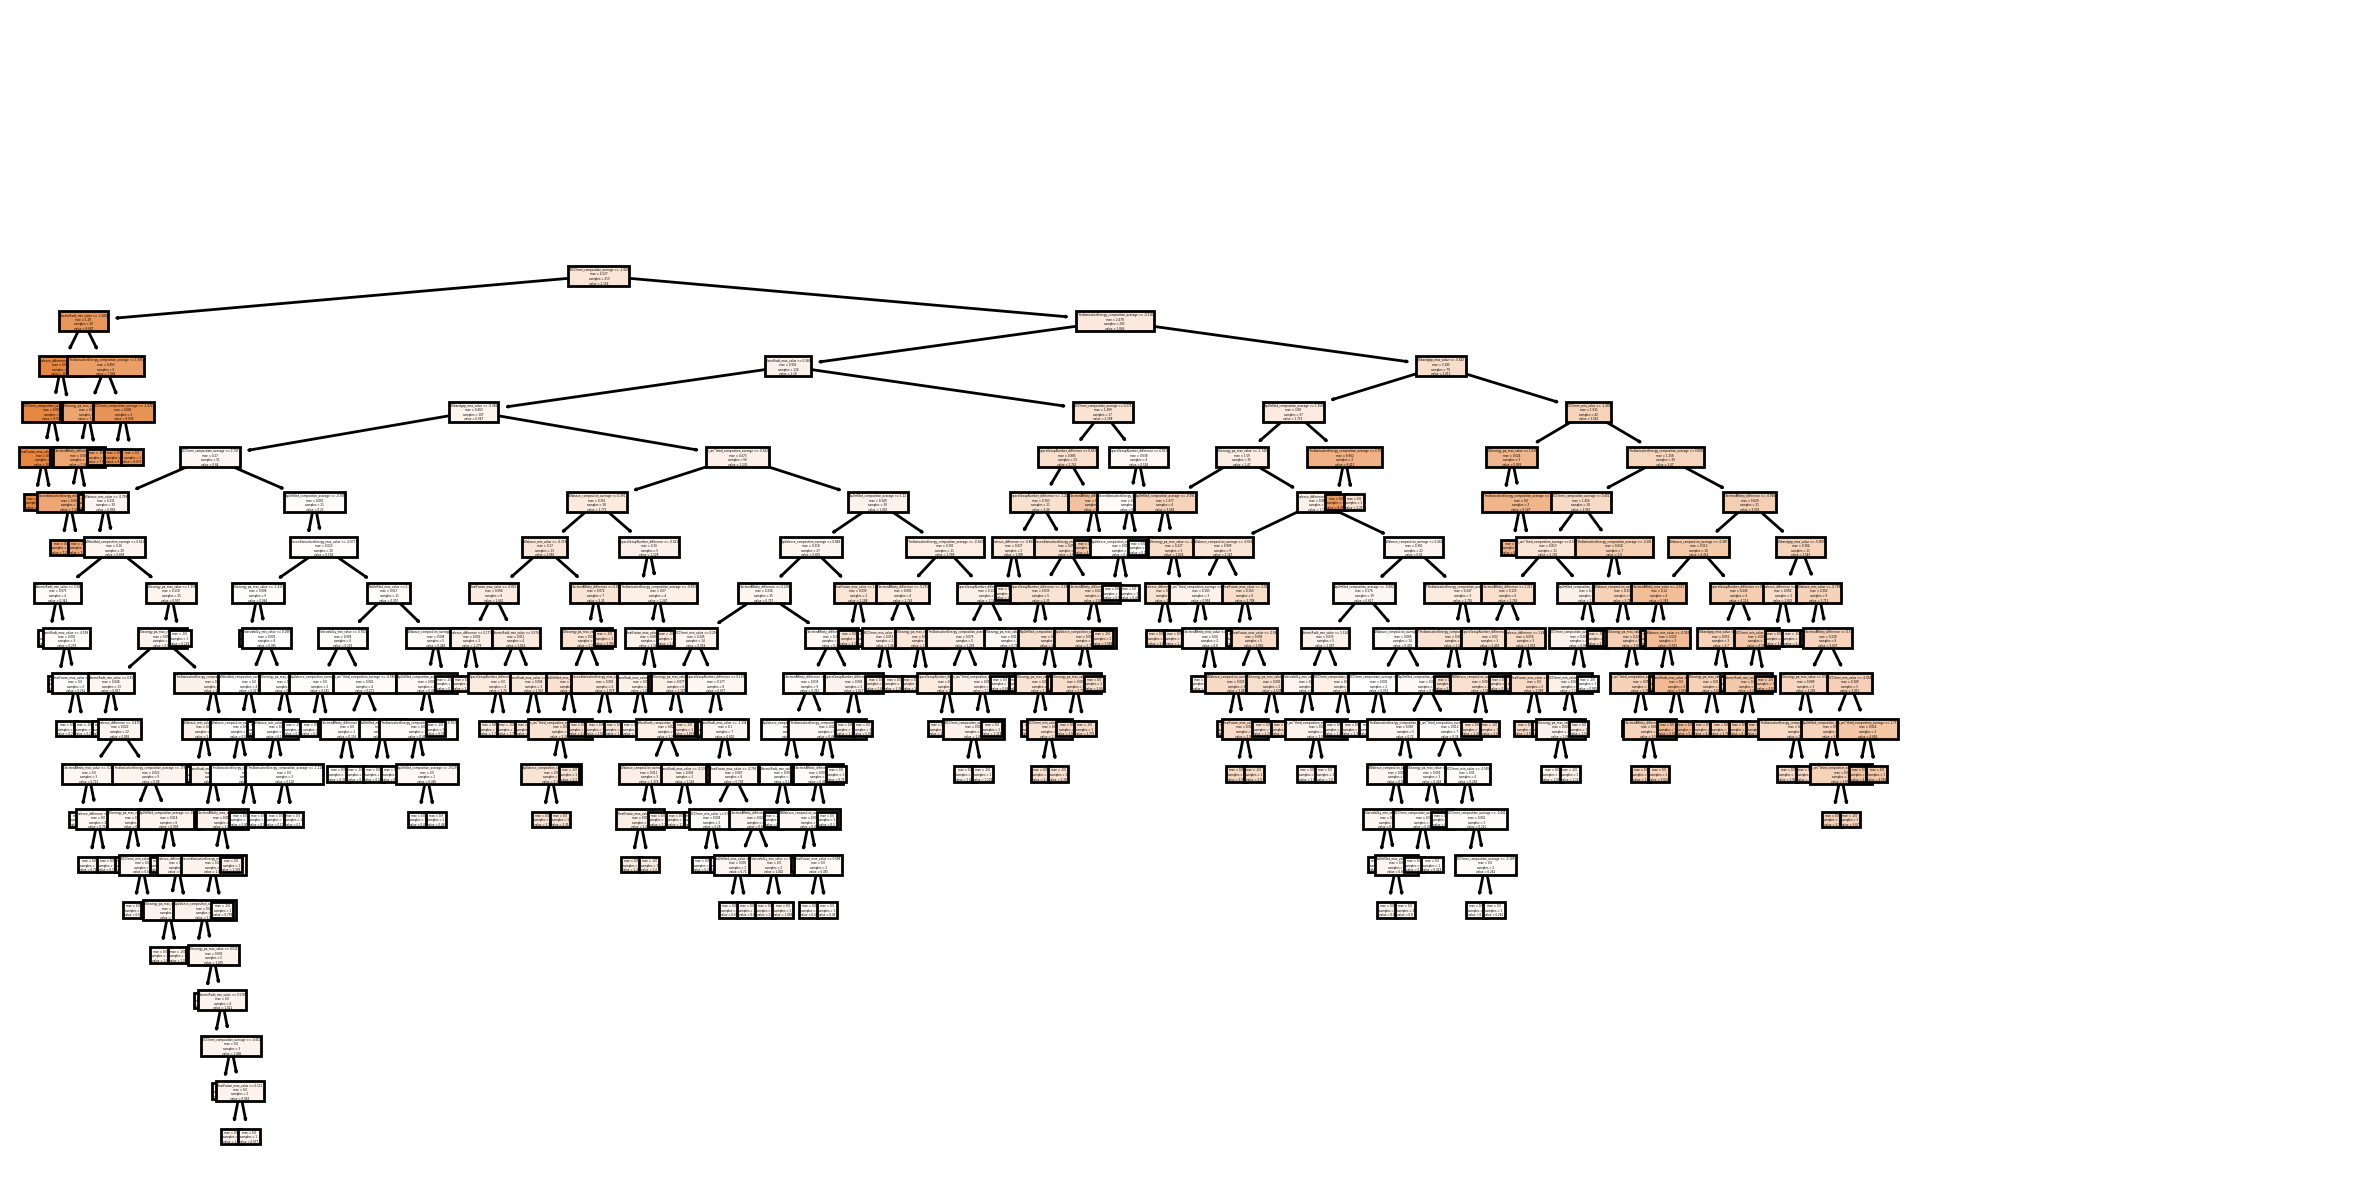

In [238]:
# Plot Decision Tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (12,6), dpi=200)
tree.plot_tree(best_dt.estimators_[5],
               feature_names = comp2, 
               class_names='Band gap',
               filled = True);
#fig.savefig(savepath+'/rf_individualtree2.png')

In [281]:
matminer_features = pd.read_csv(savepath+'/AllData-comp_diff_max_min.csv', index_col = 0)

#matminer_features.drop([0])
matminer_features

Chemical formula  AtomicNumber_composition_average  \
0              Ag2BBr                         33.500000   
1             Ag2BiO3                         33.500000   
2             Ag2GeS3                         29.000000   
3            Ag2GeSe3                         38.000000   
4            Ag2GeTe3                         47.000000   
5             Ag2HgI4                         55.142857   
6                Ag2O                         34.000000   
7             Ag2PdO2                         31.200000   
8                Ag2S                         36.666667   
9             Ag2SnS3                         32.000000   
10           Ag2SnSe3                         41.000000   
11            Ag3AsO4                         25.750000   
12            Ag3AsS3                         31.714286   
13           Ag3AsSe3                         39.428571   
14              Ag3Pd                         46.750000   
15            Ag3RuO4                         27.125000   
16            Ag3SbS3                         34.285714   
17             Ag5IO6                         28.000000   
18            Ag7AsS6                         32.714286   
19           Ag7AsSe6                         40.428571   
20            Ag7NO11                         22.315789   
21            Ag7S2I2                         42.454545   
22            Ag8GeS6                         33.600000   
23           Ag8SnSe6                         42.000000   
24          Ag9Pb4O12                         33.880000   
25             AgAlO2                         19.000000   
26             AgAlS2                         23.000000   
27            AgAlSe2                         32.000000   
28            AgAlTe2                         41.000000   
29             AgAsS2                         28.000000   
...               ...                               ...   
3585           ZrGeRu                         38.666667   
3586            ZrHCl                         19.333333   
3587          ZrInCu2                         36.750000   
3588          ZrInPd2                         45.250000   
3589          ZrInRh2                         44.750000   
3590            ZrIr2                         64.666667   
3591            ZrMo3                         41.500000   
3592          ZrNi4P2                         26.000000   
3593           ZrNiGe                         33.333333   
3594           ZrNiSb                         39.666667   
3595           ZrNiSn                         39.333333   
3596             ZrO2                         18.666667   
3597            ZrPd2                         44.000000   
3598            ZrPd3                         44.500000   
3599            ZrRe2                         63.333333   
3600             ZrRh                         42.500000   
3601           ZrRu3C                         35.600000   
3602             ZrS2                         24.000000   
3603             ZrS3                         22.000000   
3604             ZrSb                         45.500000   
3605           ZrSbRu                         45.000000   
3606             ZrSe                         37.000000   
3607            ZrSe2                         36.000000   
3608            ZrSe3                         35.500000   
3609            ZrSi2                         22.666667   
3610           ZrSiTe                         35.333333   
3611             ZrTe                         46.000000   
3612           ZrTi2O                         23.000000   
3613           ZrTiF6                         14.500000   
3614             ZrW2                         62.666667   

      AtomicNumber_difference  AtomicNumber_max_value  AtomicNumber_min_value  \
0                        42.0                    47.0                     5.0   
1                        75.0                    83.0                     8.0   
2                        31.0                    47.0                    16.0   
3                     

In [283]:
matminer_features.drop(matminer_features[matminer_features['Band gap']<0.008].index, inplace=True)

In [284]:
matminer_features['Band gap'].describe().round(3)

count    1480.000
mean        1.830
std         1.554
min         0.020
25%         0.709
50%         1.500
75%         2.422
max        11.700
Name: Band gap, dtype: float64

In [285]:
X_matm = matminer_features.drop(columns=['Chemical formula','Band gap'])
X_matm2 = X_matm[comp2]
y_matm = matminer_features['Band gap']

In [ ]:
histogram_plot(matminer_features["Band gap"].astype("float"))

In [286]:
corr_matrix = X_matm2.corr(method='pearson').abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

matm_lowcorr = X_matm2.drop(to_drop, axis=1)

In [288]:
Xcopy_matm = preprocessor.evaluate(X=matm_lowcorr, y=y_matm, make_new_dir=False)
Xcopy_matm.head()

valence_difference  ElectronAffinity_difference  \
2            0.793182                    -0.258202   
3            0.793182                    -0.333090   
4            0.793182                    -0.399063   
5            1.523225                     0.964968   
6           -2.126990                    -1.150000   

   ElectronAffinity_max_value  Polarizability_min_value  \
2                    0.436157                 -0.017239   
3                    0.384029                  0.329903   
4                    0.338107                  1.020196   
5                    1.341999                  0.830664   
6                   -0.130184                 -0.854369   

   SecondIonizationEnergy_max_value  AtomicRadii_min_value  \
2                         -0.216401               0.129776   
3                         -0.389437               0.529463   
4                         -0.389437               0.529463   
5                         -0.389437               0.369588   
6                          0.892065              -2.028528   

   HeatFusion_max_value  IsRareEarth_composition_average  GSbandgap_max_value  \
2              1.163760                        -0.411885             0.812537   
3              1.163760                        -0.411885            -0.326426   
4              1.163760                        -0.411885            -0.598380   
5             -0.626696                        -0.411885            -0.112921   
6             -0.626696                        -0.411885            -0.975058   

   ThirdIonizationEnergy_composition_average  ...  \
2                                   0.055133  ...   
3                                  -0.138637  ...   
4                                  -0.276837  ...   
5                                  -0.044773  ...   
6                                   0.712599  ...   

   IsMetalloid_composition_average  NValance_composition_average  \
2                        -0.139959                     -0.519162   
3                        -0.139959                      0.528060   
4                         1.633627                      0.528060   
5                        -0.731154                      1.066632   
6                        -0.731154                     -0.449347   

   BCCfermi_min_value  NpUnfilled_composition_average  \
2            0.158036                       -0.362687   
3            0.158036                       -0.362687   
4            0.158036                       -0.362687   
5           -0.197957                       -1.429367   
6           -0.286251                       -1.336613   

   BCCfermi_composition_average  IonicRadii_max_value  \
2                      0.041494             -0.036992   
3                     -0.548834             -0.036992   
4                      0.094208             -0.036992   
5                     -0.929503              2.486511   
6                     -1.184959              0.563842   

   NpValence_composition_average  NValance_min_value  \
2                      -0.129500           -0.160343   
3                      -0.129500            0.912478   
4                      -0.129500            0.912478   
5                       0.574149            0.912478   
6                      -1.472831           -0.160343   

   SpaceGroupNumber_difference  NdUnfilled_max_value  
2                     0.244233              -0.50536  
3                     1.057035              -0.50536  
4                    -0.945942              -0.50536  
5                     0.331319              -0.50536  
6                     1.086064              -0.50536  

[5 rows x 23 columns]

In [645]:
predict_GaAs = matminer_features[matminer_features['Chemical formula']=='GaAs']
predict_GaAs = predict_GaAs.drop(columns='Band gap')
predict_GaAs = predict_GaAs[comp2]

In [648]:
gaAs_pred = best_nn.predict(predict_GaAs)
gaAs_pred

array([58.33395027])

In [625]:
test_fraction = 0.15
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(Xcopy_matm, y_matm, test_size=test_fraction, shuffle=True,random_state=seed)

In [626]:
#y_pred = sel_model.predict(Xcopy_matm)

y_pred = best_dt.predict(X_test)

mae_score = sklearn.metrics.mean_absolute_error(y_test, y_pred)
rmse_score = sklearn.metrics.mean_squared_error(y_test, y_pred, squared=False)
r2_score = sklearn.metrics.r2_score(y_test, y_pred)
#r2adj = mastml.metrics.r2_score_adjusted(y_matm, y_pred, n_features=len(test_comp2))
print(r2_score, mae_score, rmse_score)
#0.10978492275565044 0.8542087636722431 1.3082691561864326

0.02104462942710883 0.8729394310086152 1.3575298764567922


In [248]:
### BEST DT Results
scores_DT = sklearn.model_selection.cross_validate(best_DT, X_test, y_test, cv=10, scoring=['neg_mean_squared_error','neg_root_mean_squared_error', 'neg_mean_absolute_error'])
scores_DT

{'fit_time': array([0.01497483, 0.01437831, 0.01409507, 0.01442003, 0.01413298,
        0.01416397, 0.01421213, 0.01421213, 0.01381612, 0.0137651 ]),
 'score_time': array([0.00292659, 0.00287509, 0.00287557, 0.00289488, 0.0028739 ,
        0.0028789 , 0.0028801 , 0.00288534, 0.00287938, 0.00287223]),
 'test_neg_mean_squared_error': array([-0.82942533, -0.87894986, -1.07085825, -0.99050865, -1.07541603,
        -1.39992076, -1.67161973, -1.19461413, -0.91627349, -1.39450426]),
 'test_neg_root_mean_squared_error': array([-0.91072791, -0.93752326, -1.03482281, -0.99524301, -1.03702267,
        -1.18318247, -1.29291134, -1.09298405, -0.95722176, -1.1808913 ]),
 'test_neg_mean_absolute_error': array([-0.63631043, -0.51512175, -0.65465532, -0.65368496, -0.68030896,
        -0.70993423, -0.73990754, -0.72687855, -0.60765232, -0.70584451])}

In [217]:
## below is for %70 split from >0.2eV matminer data set
scores = sklearn.model_selection.cross_validate(sel_model, X_test, y_test, scoring=['neg_mean_squared_error','neg_root_mean_squared_error', 'neg_mean_absolute_error'])
scores

{'fit_time': array([3.59084702, 3.62768507, 3.64064455, 3.54947495, 3.57564139]),
 'score_time': array([0.07396245, 0.078439  , 0.07515907, 0.07526779, 0.0773766 ]),
 'test_neg_mean_squared_error': array([-0.56392346, -0.53021264, -0.59294789, -0.97868329, -0.69661572]),
 'test_neg_root_mean_squared_error': array([-0.75094837, -0.72815702, -0.7700311 , -0.98928423, -0.83463508]),
 'test_neg_mean_absolute_error': array([-0.48639988, -0.51501132, -0.47178175, -0.60903566, -0.54753902])}

In [ ]:
#Matminer Data set as test, R2, MAE, RMSE
# 0.19651838546873823 0.903226321732107 1.383455389365808

# 15% of Matminer Data set as test set
# 0.033407631642455415 0.8411847551646711 1.3753854657402387

# 30% 
# 0.10978492275565044 0.8542087636722431 1.3082691561864326

In [660]:
modelPath = savepath+'/RandomForestRegressor_RepeatedKFold_SklearnPreprocessor_NoSelect_05_21_19_29_41/'
X_test_for = pd.read_excel(modelPath+'X_test.xlsx')
y_test_for = pd.read_excel(modelPath+'y_test.xlsx')
pathList[-13]

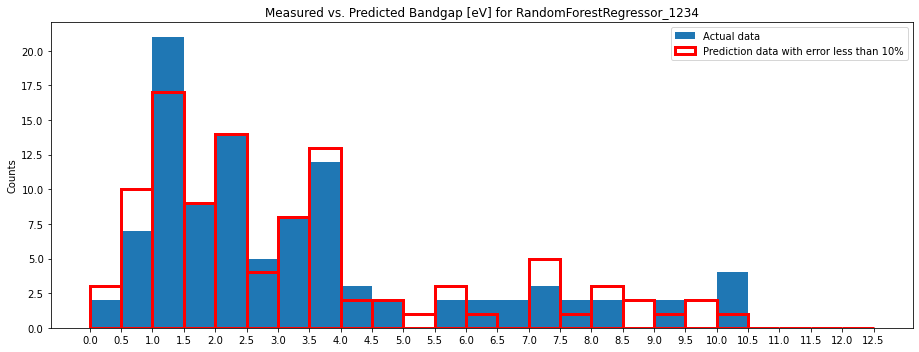

In [135]:
plot_lim = 13 #eV ### Maximum value of the band gaps in the target data set.
fraction = False ### If True, gives fraction/percentile of the counts instead of just counts

# FIGURE
plt.figure(figsize=(25,5))

i=-1
output_Df2 = df_list[i].drop(df_list[i].loc[df_list[i]['Error(%)'] > 10].index) ### Bu grafiği >10 yapınca işler ilginçleşiyor

plt.subplot(1,2,1)
# Actual band gap data set
plt.hist(output_Df2["Band Gap"], bins=np.arange(0,plot_lim,0.5), density=fraction, label='Actual data')
#Predicted band gap data set
#plt.hist(output_Df2["Band Gap"],bins=np.arange(0,plot_lim,0.5),alpha=0.5, label='Prediction data with error less than 10%') #Plots # of predictions
# Below draws rectangles instead of overlapping. This also gives transparency.
plt.hist(output_Df2["Predicted"],bins=np.arange(0,plot_lim,0.5), edgecolor='r', lw=3,fc="None", density=fraction, label='Prediction data with error less than 10%') #Plots # of predictions

## Figure configurations such as title etc.
#plt.title('Measured vs. Predicted Bandgap [eV] for '+file_df['Model'].iloc[i]+'_'+file_df['HH'].iloc[i]+file_df['mm'].iloc[i]) #v2
#plt.title('Measured vs. Predicted Bandgap [eV] for '+flist[i])
plt.xticks(np.arange(0,plot_lim,0.5))
plt.ylabel('Counts')
plt.legend(loc='upper right')

##ax[i].hist(output_Df2["Band Gap"],bins=range(13),density=1) ## Gives fraction of predictions

plt.show()

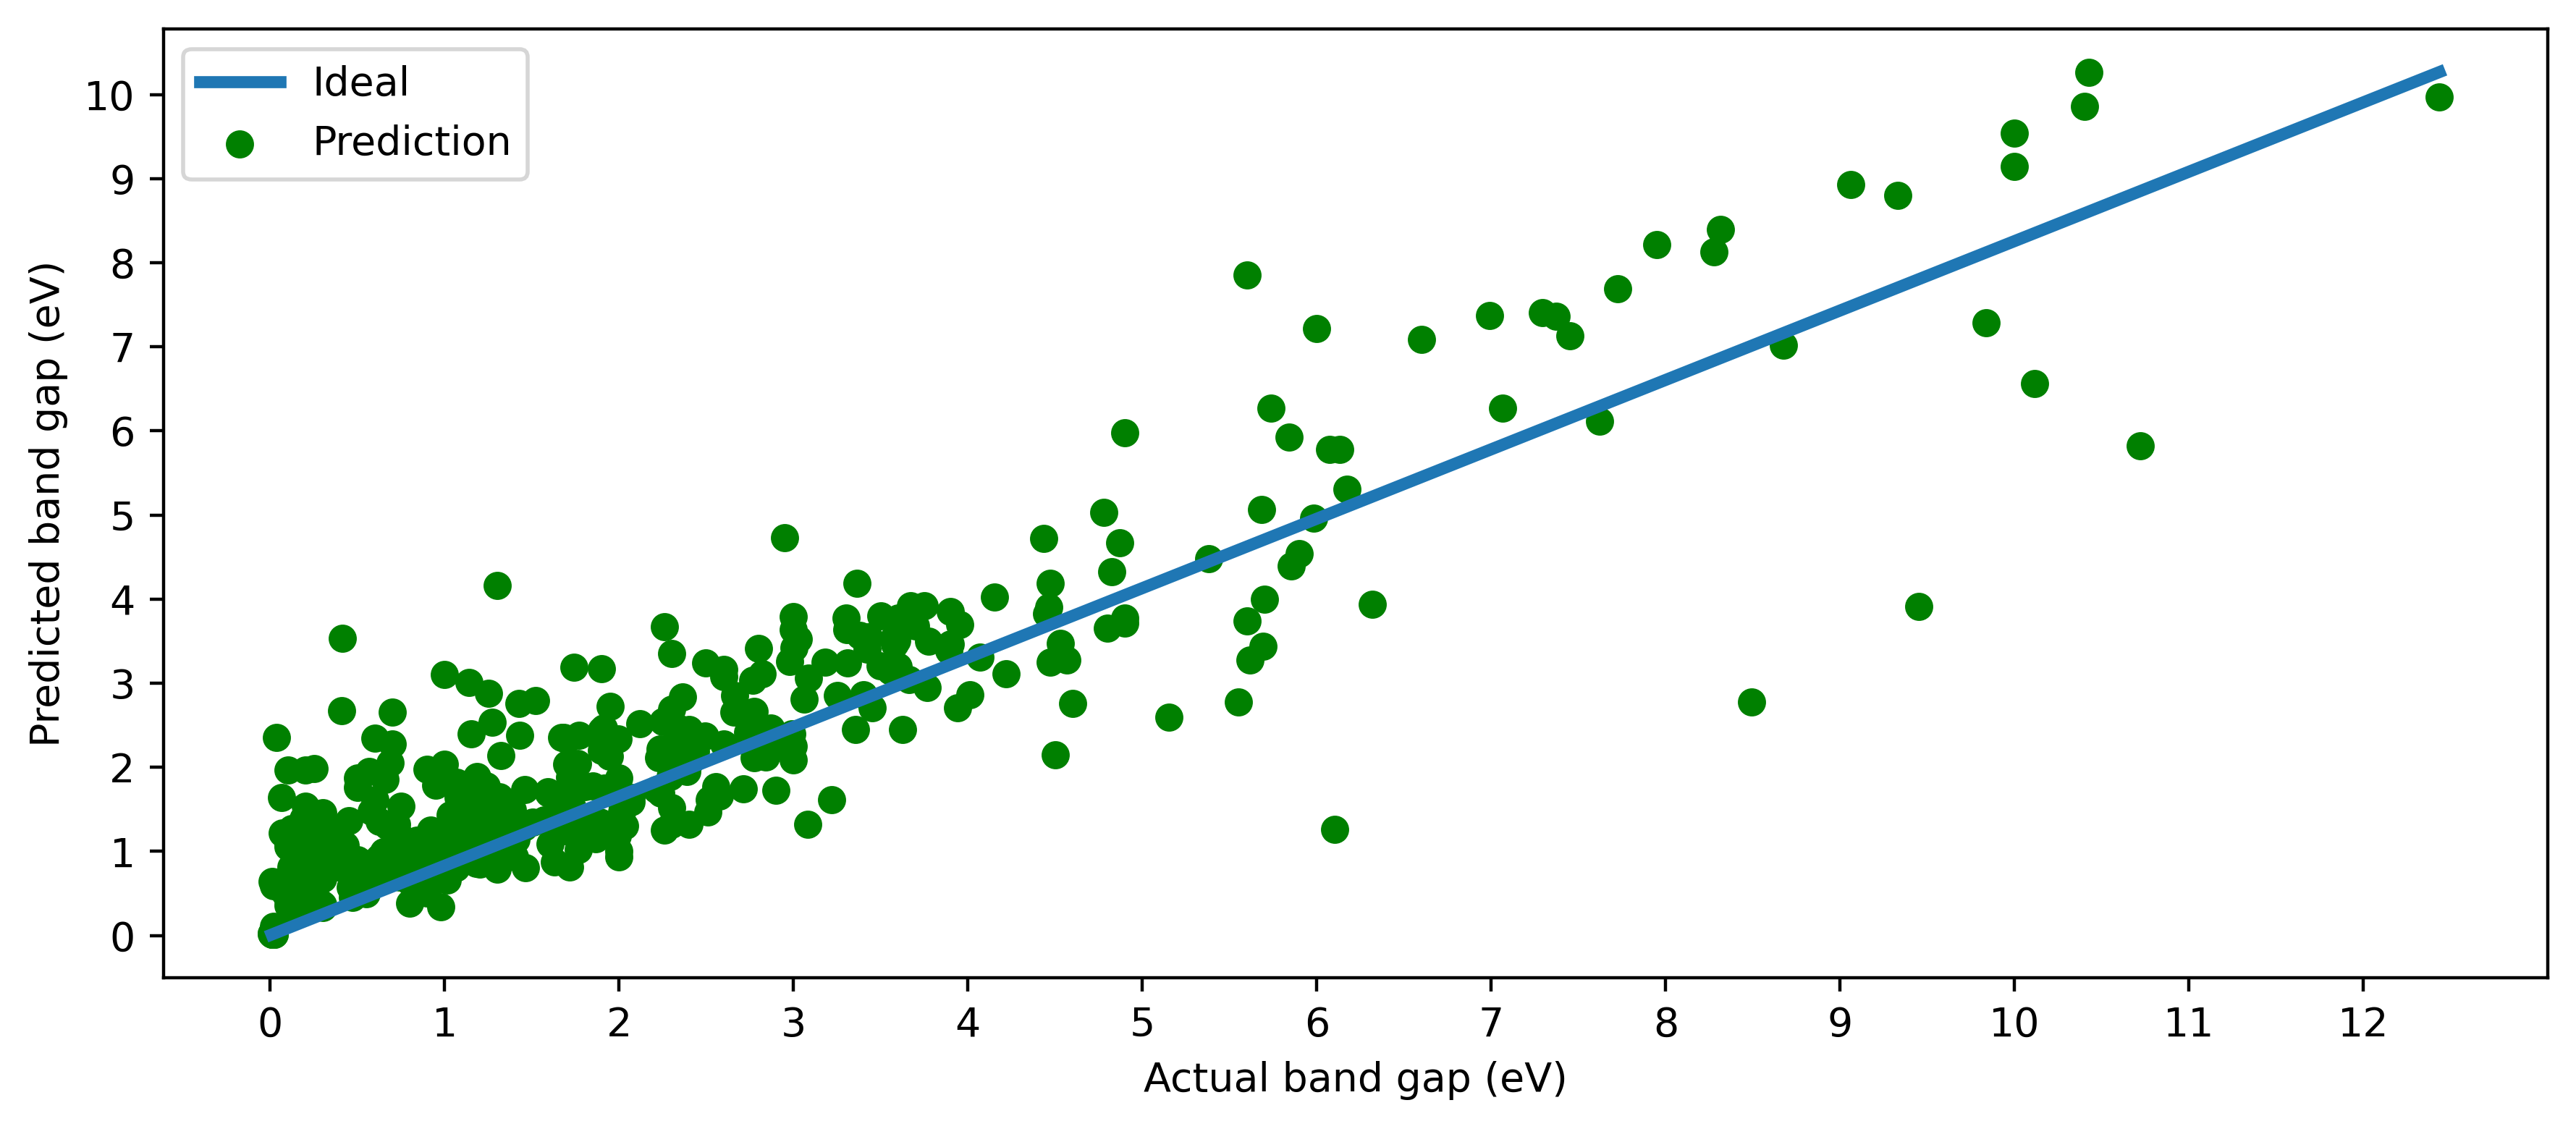

In [131]:
plot_limit = 13 #[eV]
df_idx = -1 #-1 for last trained model

fig1,ax1 = plt.subplots(figsize=(9,4), dpi=400)
ax1.set_xticks(np.arange(-2,plot_limit,1))
ax1.set_yticks(np.arange(-2,plot_limit,1))
ax1.scatter(df_list[df_idx]['Band Gap'], df_list[df_idx]['Predicted'], color='green')
#ax1.errorbar.set_color('black')
#ax1.get_lines()[0].set_color('green')
plt.ylabel('Predicted band gap (eV)')
plt.xlabel('Actual band gap (eV)')
#plt.title('Scatter Plot with Errors')

ax1.plot([df_list[df_idx]['Band Gap'].min(), df_list[df_idx]['Band Gap'].max()], [df_list[df_idx]['Predicted'].min(), df_list[df_idx]['Predicted'].max()], '-', lw=3)
ax1.legend(["Ideal", "Prediction"])

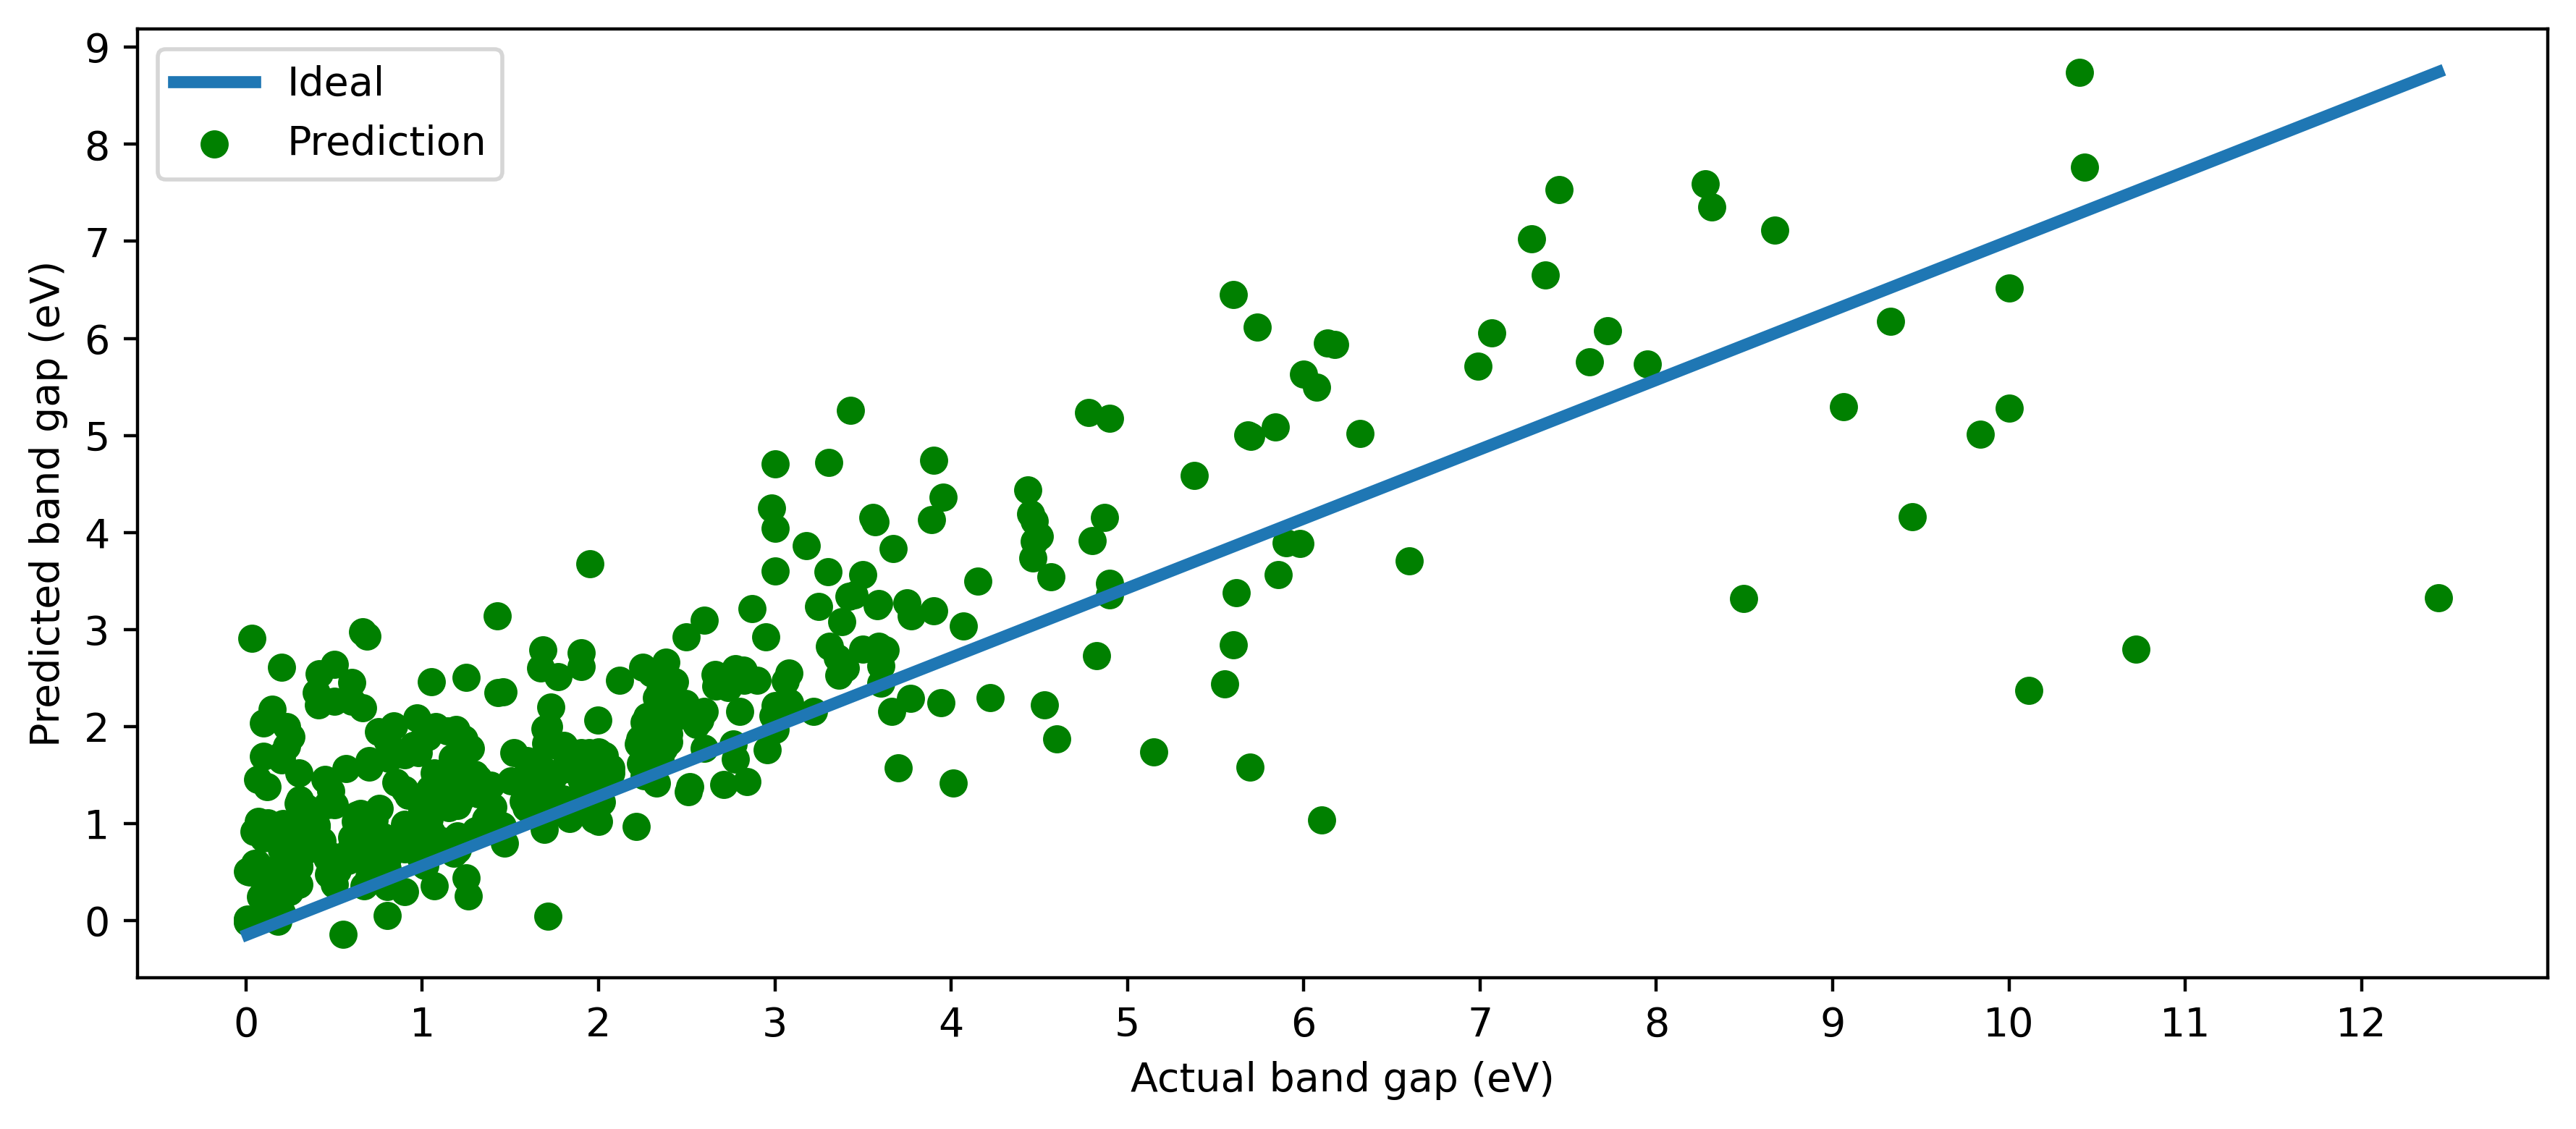

In [272]:
### KRR MAE:0.551
plot_limit = 13 #[eV]
df_idx = -1 #-1 for last trained model

fig1,ax1 = plt.subplots(figsize=(9,4), dpi=400)
ax1.set_xticks(np.arange(-2,plot_limit,1))
ax1.set_yticks(np.arange(-2,plot_limit,1))
ax1.scatter(df_list[df_idx]['Band Gap'], df_list[df_idx]['Predicted'], color='green')
#ax1.errorbar.set_color('black')
#ax1.get_lines()[0].set_color('green')
plt.ylabel('Predicted band gap (eV)')
plt.xlabel('Actual band gap (eV)')
#plt.title('Scatter Plot with Errors')

ax1.plot([df_list[df_idx]['Band Gap'].min(), df_list[df_idx]['Band Gap'].max()], [df_list[df_idx]['Predicted'].min(), df_list[df_idx]['Predicted'].max()], '-', lw=3)
ax1.legend(["Ideal", "Prediction"])

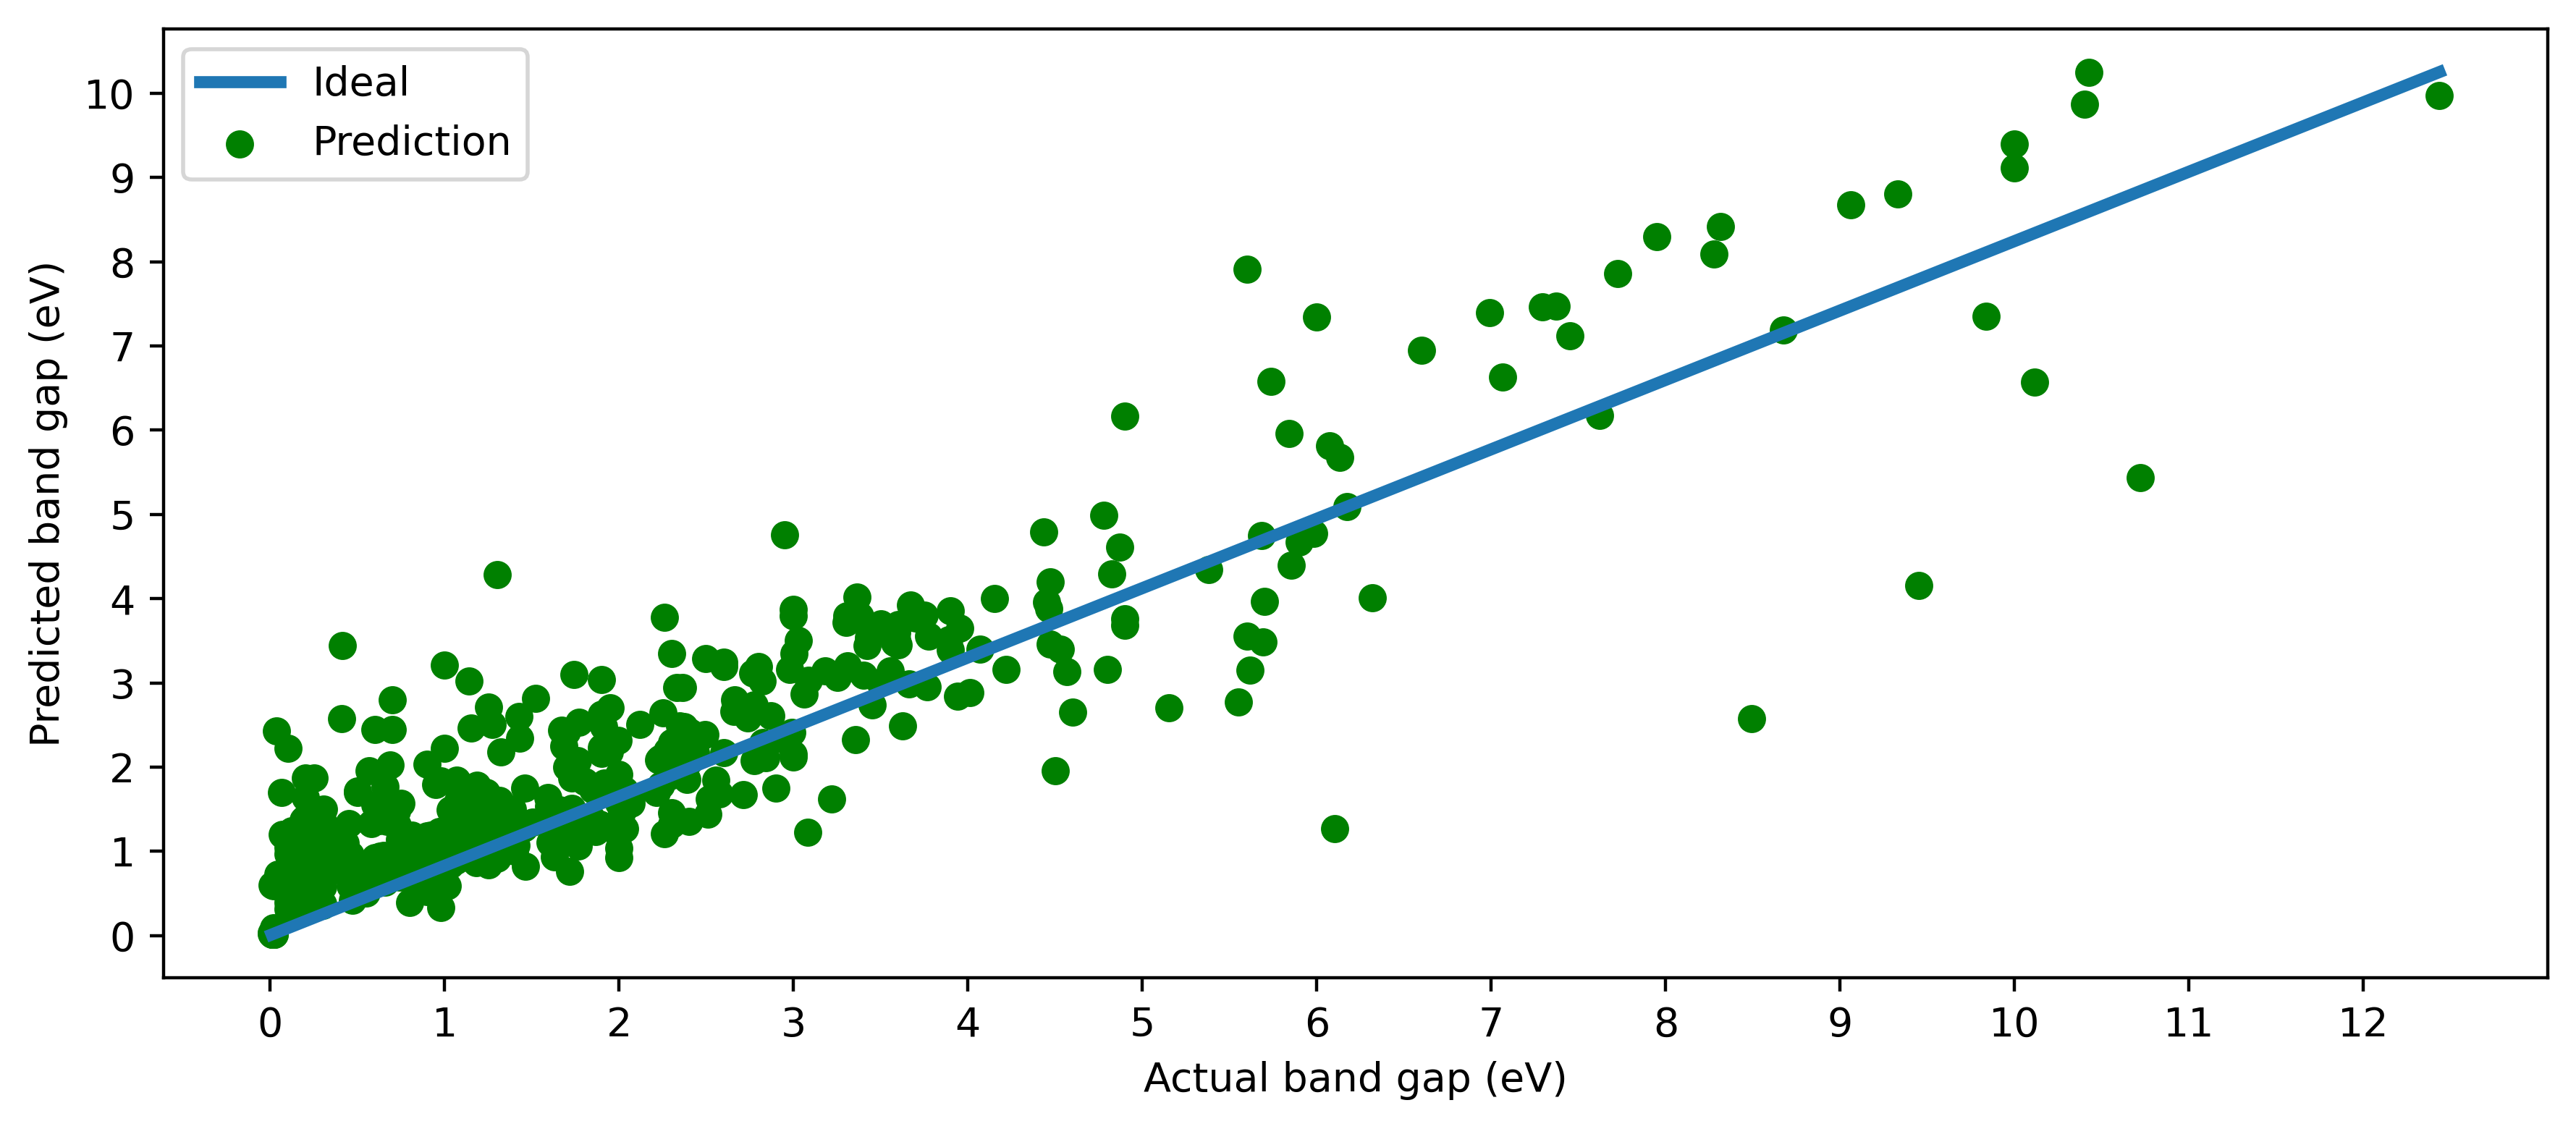

In [279]:
### RF(100) MAE:0.480
plot_limit = 13 #[eV]
df_idx = -1 #-1 for last trained model

fig1,ax1 = plt.subplots(figsize=(9,4), dpi=400)
ax1.set_xticks(np.arange(-2,plot_limit,1))
ax1.set_yticks(np.arange(-2,plot_limit,1))
ax1.scatter(df_list[df_idx]['Band Gap'], df_list[df_idx]['Predicted'], color='green')
#ax1.errorbar.set_color('black')
#ax1.get_lines()[0].set_color('green')
plt.ylabel('Predicted band gap (eV)')
plt.xlabel('Actual band gap (eV)')
#plt.title('Scatter Plot with Errors')

ax1.plot([df_list[df_idx]['Band Gap'].min(), df_list[df_idx]['Band Gap'].max()], [df_list[df_idx]['Predicted'].min(), df_list[df_idx]['Predicted'].max()], '-', lw=3)
ax1.legend(["Ideal", "Prediction"])

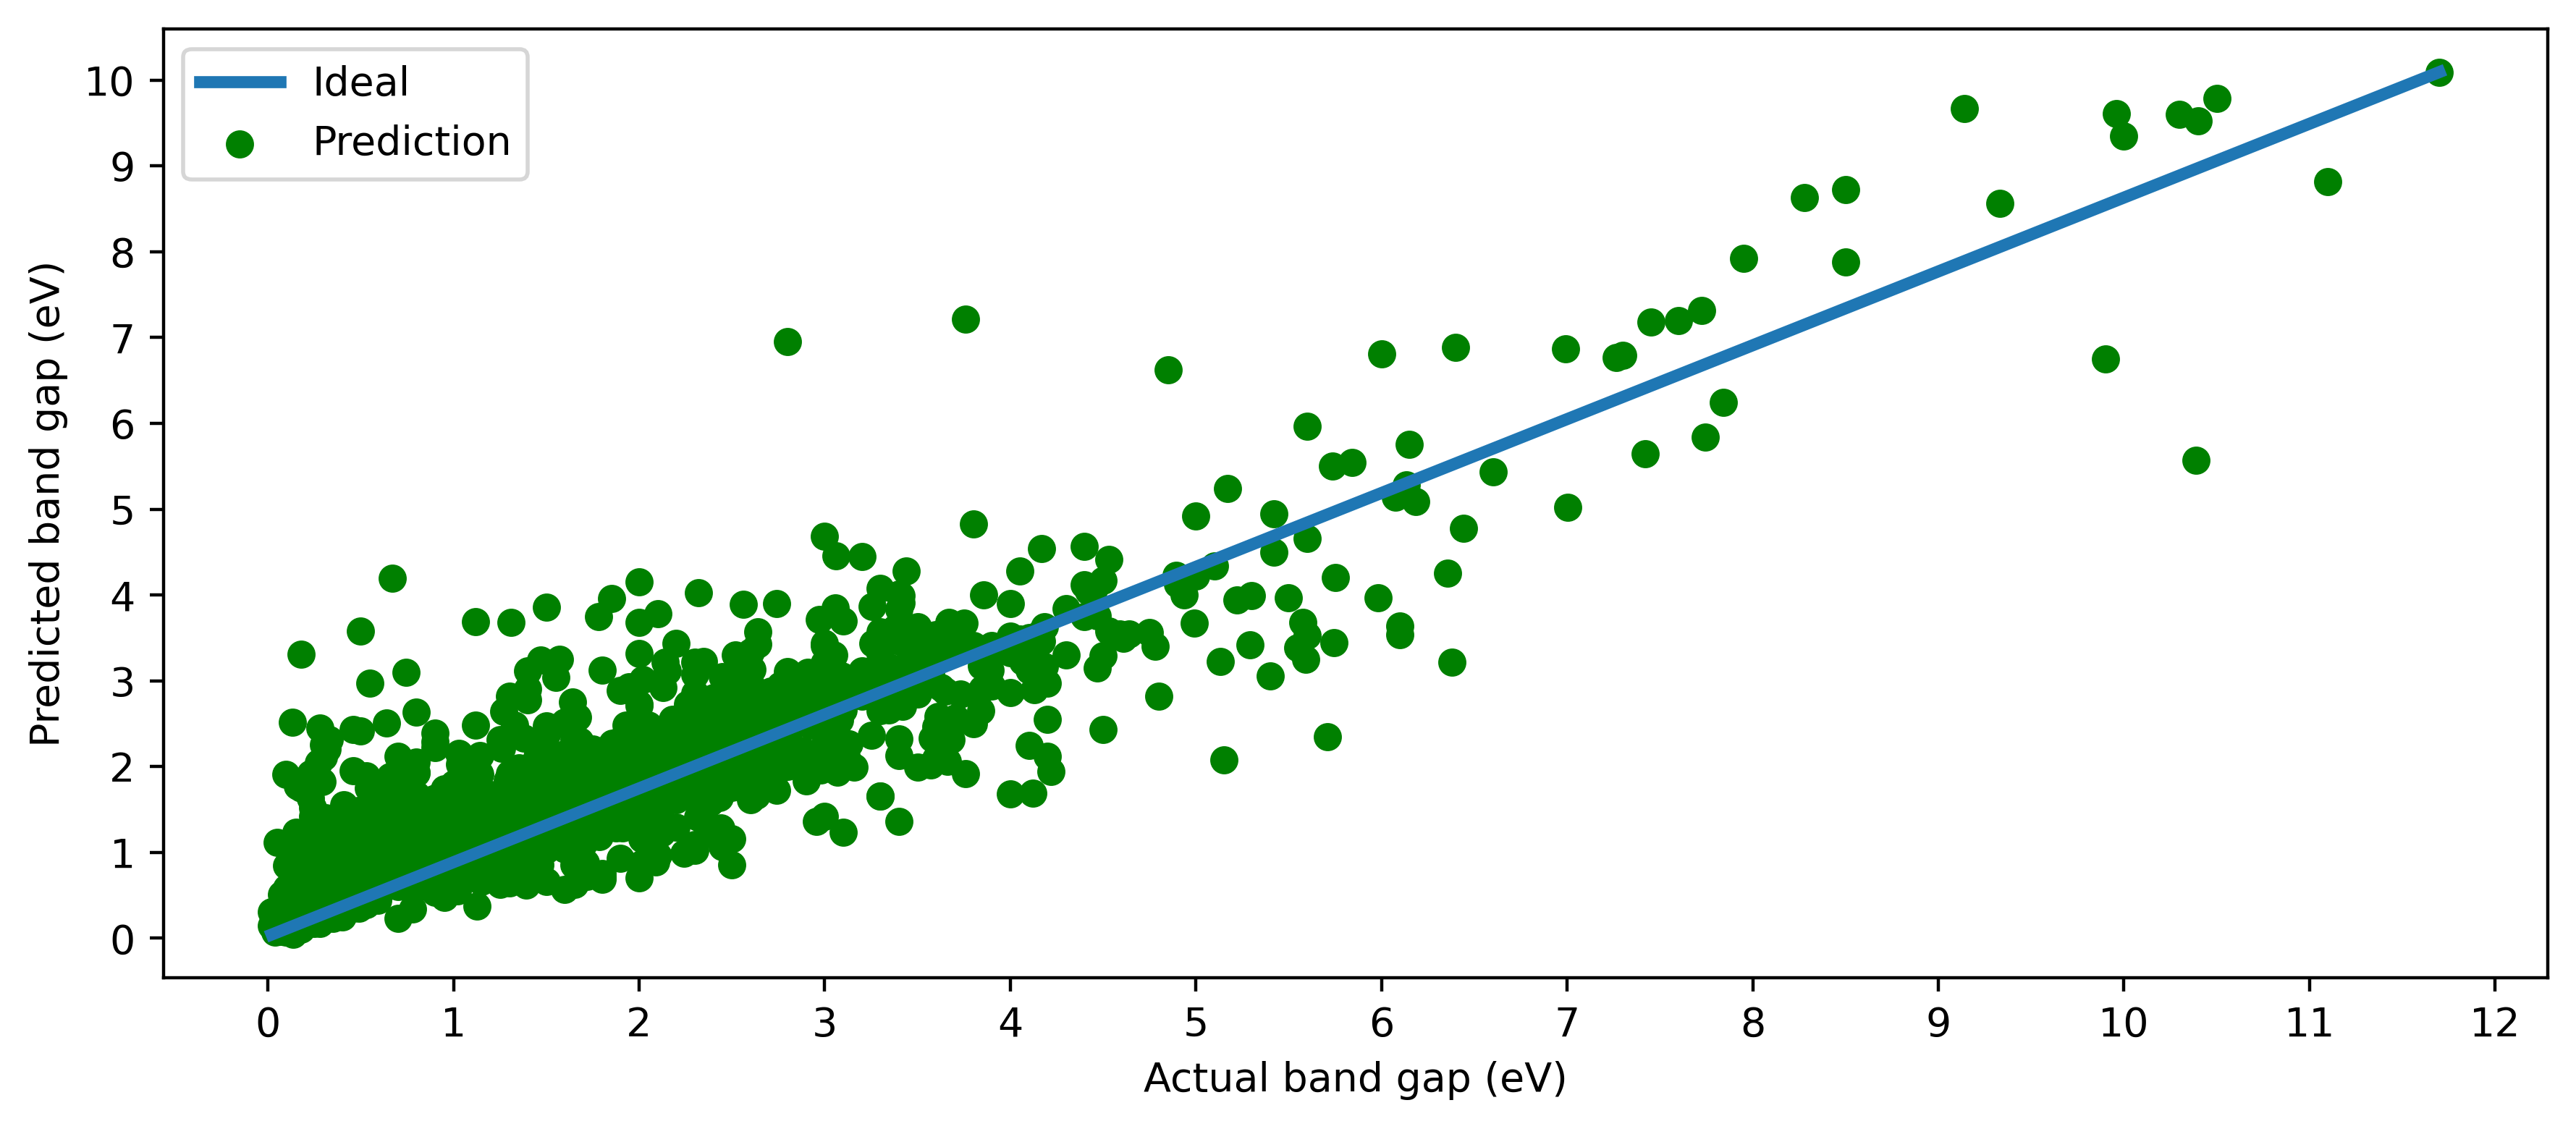

In [291]:
plot_limit = 13 #[eV]
df_idx = -1 #-1 for last trained model

fig1,ax1 = plt.subplots(figsize=(9,4), dpi=400)
ax1.set_xticks(np.arange(-2,plot_limit,1))
ax1.set_yticks(np.arange(-2,plot_limit,1))
ax1.scatter(df_list[df_idx]['Band Gap'], df_list[df_idx]['Predicted'], color='green')
#ax1.errorbar.set_color('black')
#ax1.get_lines()[0].set_color('green')
plt.ylabel('Predicted band gap (eV)')
plt.xlabel('Actual band gap (eV)')
#plt.title('Scatter Plot with Errors')

ax1.plot([df_list[df_idx]['Band Gap'].min(), df_list[df_idx]['Band Gap'].max()], [df_list[df_idx]['Predicted'].min(), df_list[df_idx]['Predicted'].max()], '-', lw=3)
ax1.legend(["Ideal", "Prediction"])

In [24]:
import seaborn as sns
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set_style("whitegrid") ## Draws grid lines to graphs with white background "blackgrid"
#sns.set(style="ticks") ## This removes any grid line

[Text(0, 0.5, 'Predicted band gap (eV)'), Text(0.5, 0, 'Actual band gap (eV)')]

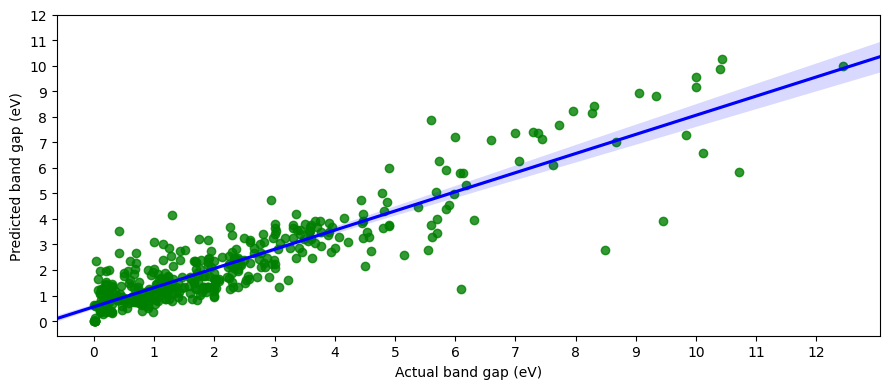

In [30]:
fig1 = plt.figure(figsize=(9,4),dpi=100) #-15 103
sct_plot = sns.regplot(x="Band Gap", y="Predicted", data=df_list[-1],ci=90, fit_reg=True,color='red', 
                      scatter_kws={'color':'green'}, line_kws={"color":'blue'})
sct_plot.set_xticks(np.arange(0,13,1))
sct_plot.set_yticks(np.arange(0,13,1))

sct_plot.set(ylabel='Predicted band gap (eV)', xlabel='Actual band gap (eV)')

#plt.xticks(ticks=np.arange(0,13,1))
#sct_plot.set_xticks(np.arange(0,13,1))


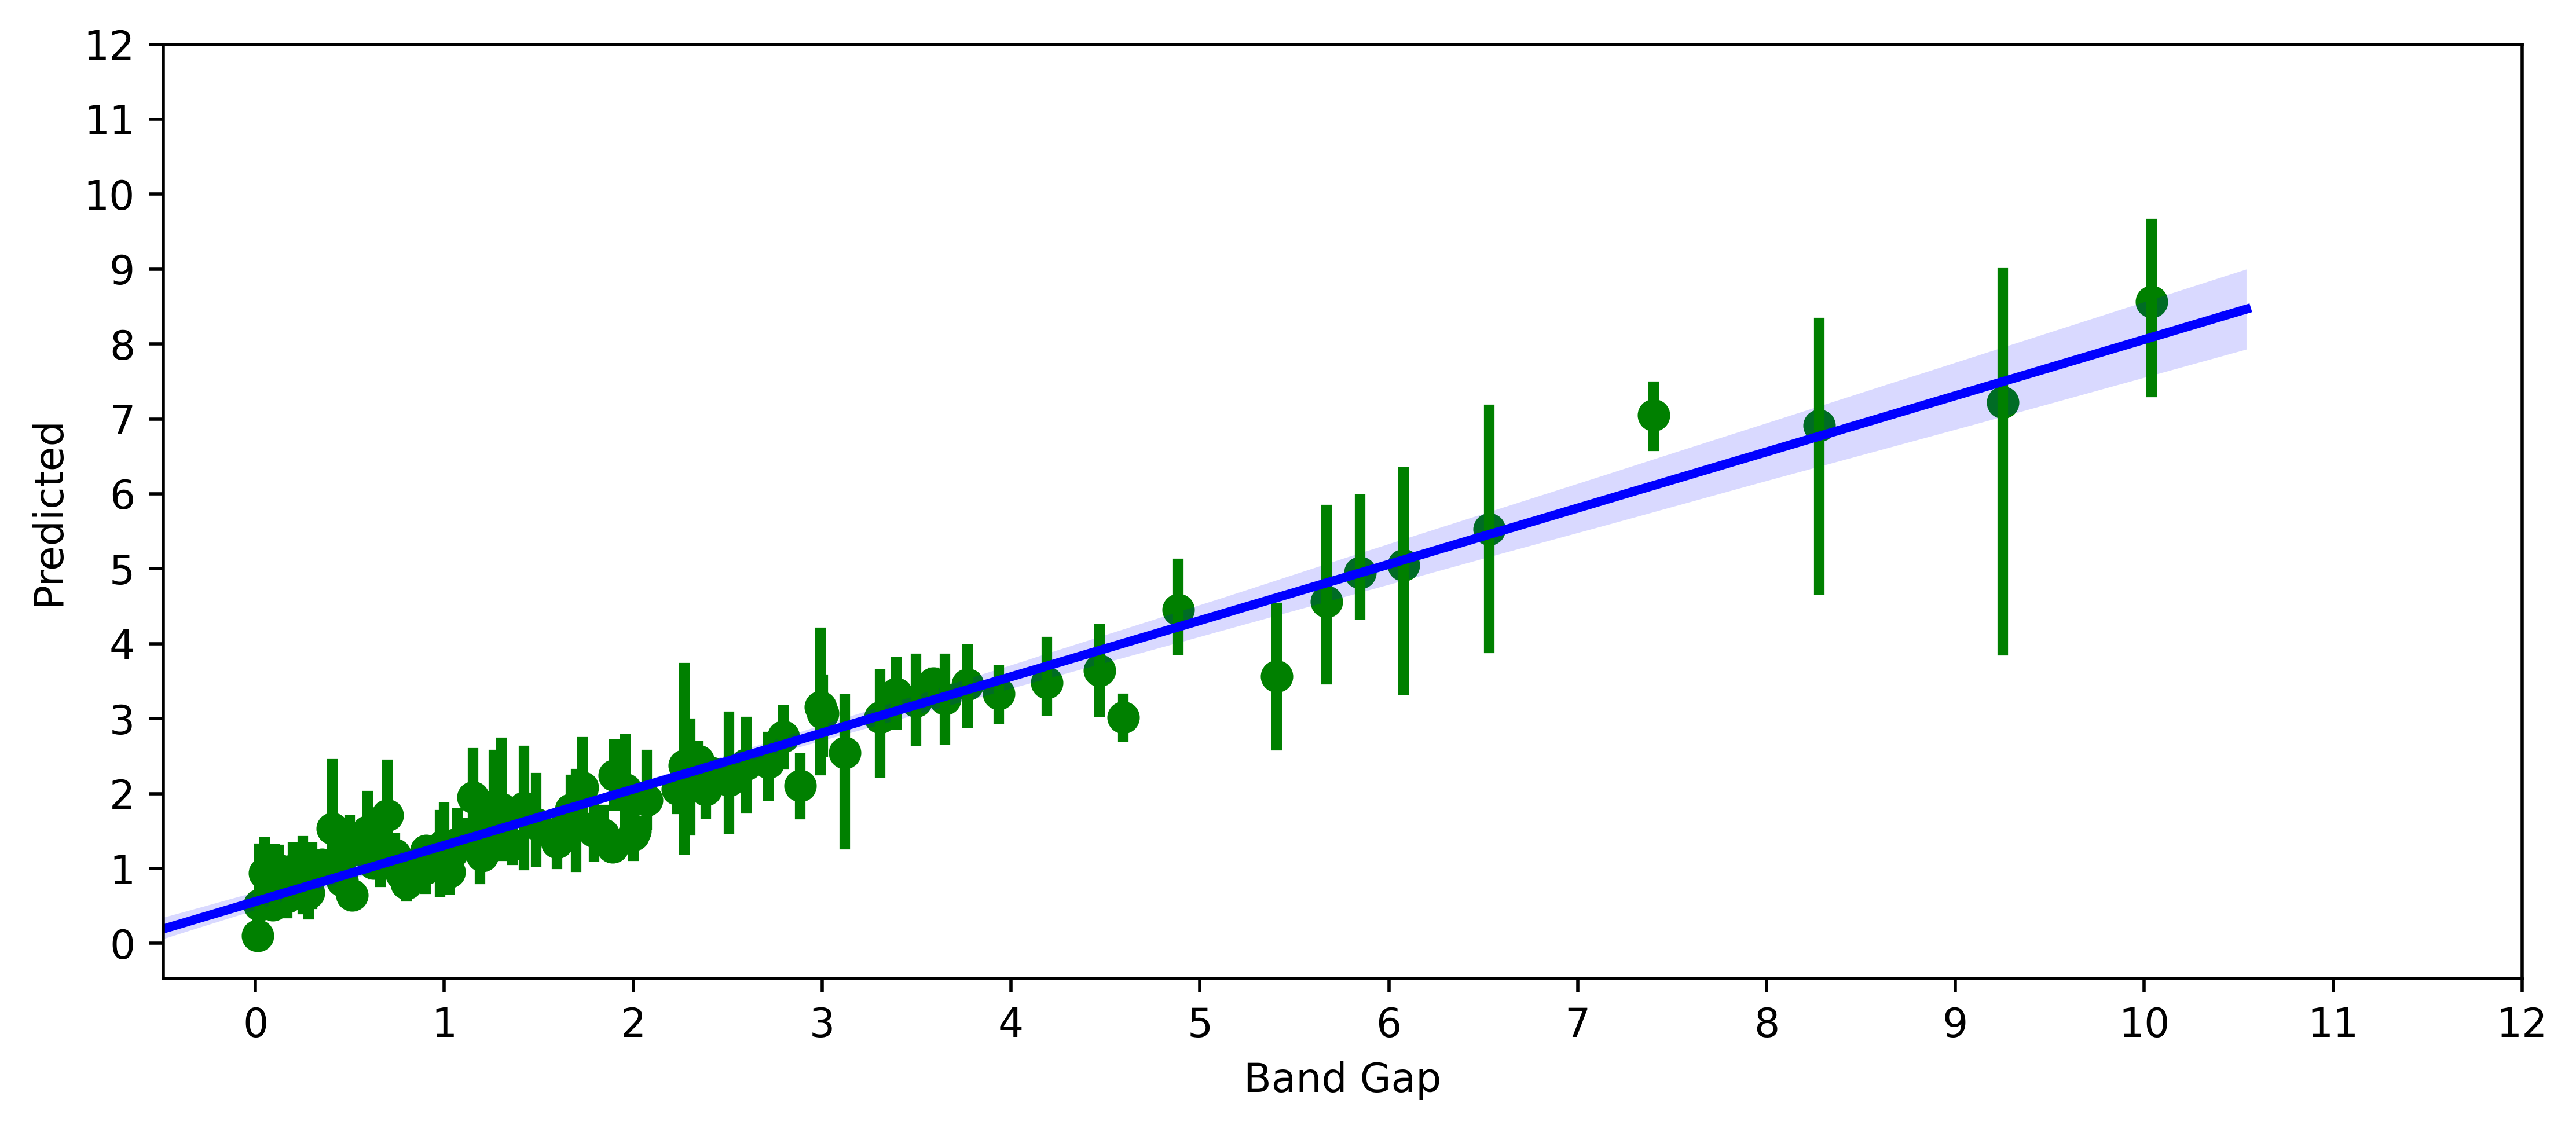

In [691]:
plt.figure(figsize=(9,4),dpi=500)
snsplot = sns.regplot(x="Band Gap", y="Predicted", data=df_list[-1], fit_reg=True,x_bins=90, color='red', 
                      scatter_kws={'color':'green'}, line_kws={"color":'blue'})

snsplot.set_xticks(np.arange(0,13,1))
snsplot.set_yticks(np.arange(0,13,1))

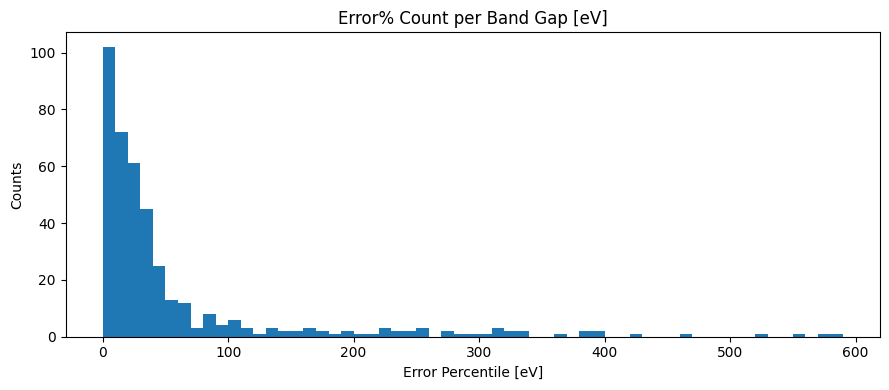

In [21]:
### PLOTS %Error count
plot_limit = 600
fig1,ax1 = plt.subplots(figsize=(9,4),dpi=100)
ax1.hist(df_list[-1]['Error(%)'],bins=np.arange(0,plot_limit,10),density=0) #density=1 gives % counts 
#ax1.set_xticks(np.arange(0,plot_limit,50))
#ax1.set_yticks(np.arange(0,50,5))
ax1.set_xlabel('Error Percentile [eV]')
ax1.set_ylabel('Counts')
plt.title('Error% Count per Band Gap [eV]')
plt.show()


<Figure size 9600x9600 with 0 Axes>

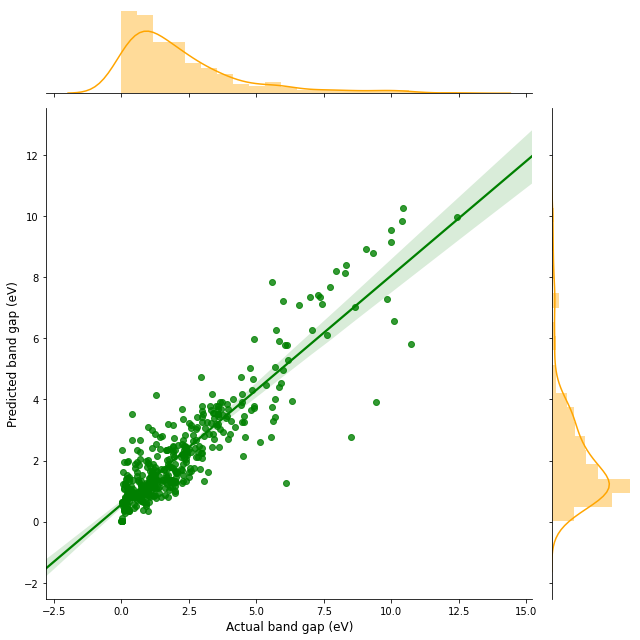

In [444]:
plt.figure(figsize=(12,12), dpi=800)
graph = sns.jointplot(x="Band Gap", y="Predicted", data=df_list[-1], kind="reg",#color='orange', 
                      marginal_kws={'color':'orange'}, joint_kws={"color":'green'},
                     height=9)
#graph.set_axis_labels('x', 'y', fontsize=16) 
graph.ax_joint.set_xlabel('Actual band gap (eV)', fontsize=12)
graph.ax_joint.set_ylabel('Predicted band gap (eV)',fontsize=12)
plt.tight_layout()

Different feature selectors are shown here

In [428]:
model = SklearnModel(model='RandomForestRegressor', random_state=seed)
selector = EnsembleModelFeatureSelector(model=model, 
                                        n_features_to_select=35)
X_RF = selector.evaluate(X=features_df, y=y, savepath=savepath, make_new_dir=False)

#display the selected features
X_RF.head()

#Plot the learning curve
#LearningCurve().evaluate(model=model,X=Xcopy, y=y,savepath=savepath,selector=selector,make_new_dir=True)

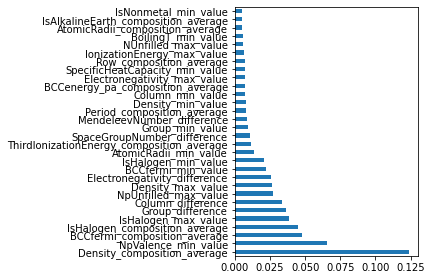

In [356]:
model__ = sklearn.ensemble.ExtraTreesRegressor()
model__.fit(features_df,y)
#print(model__.feature_importances_)
feat_importances = pd.Series(model__.feature_importances_, index=features_df.columns)
feat_importances.nlargest(30).plot(kind='barh')

plt.show()

In [357]:
extTreeFeatures = feat_importances.nlargest(25).keys()
extTreeFeatures

Index(['Density_composition_average', 'NpValence_min_value',
       'BCCfermi_composition_average', 'IsHalogen_composition_average',
       'IsHalogen_max_value', 'Group_difference', 'Column_difference',
       'NpUnfilled_max_value', 'Density_max_value',
       'Electronegativity_difference', 'BCCfermi_min_value',
       'IsHalogen_min_value', 'AtomicRadii_min_value',
       'ThirdIonizationEnergy_composition_average',
       'SpaceGroupNumber_difference', 'Group_min_value',
       'MendeleevNumber_difference', 'Period_composition_average',
       'Density_min_value', 'Column_min_value',
       'BCCenergy_pa_composition_average', 'Electronegativity_max_value',
       'SpecificHeatCapacity_min_value', 'Row_composition_average',
       'IonizationEnergy_max_value'],
      dtype='object')

In [302]:
# extTreeFeatures
scores_etf = sklearn.model_selection.cross_validate(sel_model, features_df[extTreeFeatures], y, cv=5, scoring=['neg_mean_squared_error','neg_root_mean_squared_error', 'neg_mean_absolute_error'])
scores_etf

{'fit_time': array([1.97578573, 1.96914101, 1.97083759, 1.96825695, 1.95300031]),
 'score_time': array([0.06305027, 0.06308055, 0.06296349, 0.06448364, 0.06438255]),
 'test_neg_mean_squared_error': array([-0.88865833, -0.60286607, -1.87984915, -0.72826731, -1.13412588]),
 'test_neg_root_mean_squared_error': array([-0.94268676, -0.77644451, -1.37107591, -0.85338579, -1.06495346]),
 'test_neg_mean_absolute_error': array([-0.66091763, -0.62210429, -0.94741973, -0.6155374 , -0.76798948])}

In [337]:
# SelectKBest
feature_selector = sklearn.feature_selection.SelectKBest(score_func=sklearn.feature_selection.f_regression, k = 25)
fit = feature_selector.fit(features_df,y)  # fit to data
# get_support gives a vector [False, False, True, False....]
kbest_features = features_df.columns[fit.get_support()]
print(kbest_features)


Index(['AtomicRadii_difference', 'AtomicRadii_min_value',
       'BCCfermi_composition_average', 'BCCfermi_max_value',
       'BCCfermi_min_value', 'CovalentRadii_difference',
       'Density_composition_average', 'Density_min_value',
       'Electronegativity_difference', 'Electronegativity_max_value',
       'FirstIonizationEnergy_difference', 'FirstIonizationEnergy_max_value',
       'IonizationEnergy_difference', 'IonizationEnergy_max_value',
       'IsHalogen_composition_average', 'IsHalogen_max_value',
       'IsHalogen_min_value', 'SecondIonizationEnergy_composition_average',
       'SecondIonizationEnergy_max_value',
       'ThermalExpansionCoefficient_composition_average',
       'ThermalExpansionCoefficient_difference',
       'ThermalExpansionCoefficient_max_value',
       'ThirdIonizationEnergy_composition_average',
       'ThirdIonizationEnergy_max_value', 'ThirdIonizationEnergy_min_value'],
      dtype='object')


In [338]:
features_df[kbest_features]

AtomicRadii_difference  AtomicRadii_min_value  \
0                     0.714                  0.730   
1                     0.174                  1.270   
2                     0.044                  1.400   
3                     0.156                  1.444   
4                     0.304                  1.140   
5                     0.454                  0.990   
6                     0.114                  1.330   
7                     0.524                  0.920   
8                     0.156                  1.444   
9                     0.700                  0.730   
10                    0.040                  1.390   
11                    0.450                  0.980   
12                    0.510                  0.920   
13                    0.150                  1.280   
14                    0.160                  1.430   
15                    0.000                  1.390   
16                    0.660                  0.730   
17                    0.120                  1.270   
18                    0.120                  1.270   
19                    0.120                  1.270   
20                    0.010                  1.390   
21                    0.210                  1.390   
22                    0.120                  1.270   
23                    0.250                  1.140   
24                    0.060                  1.330   
25                    0.010                  1.390   
26                    0.210                  1.390   
27                    0.000                  0.980   
28                    0.250                  0.730   
29                    0.410                  0.980   
..                      ...                    ...   
394                   0.591                  0.730   
395                   0.640                  0.730   
396                   0.100                  1.270   
397                   0.030                  1.370   
398                   0.230                  1.370   
399                   1.080                  0.730   
400                   0.890                  0.920   
401                   1.210                  0.730   
402                   0.550                  1.390   
403                   0.670                  1.270   
404                   0.350                  1.590   
405                   0.058                  1.332   
406                   0.052                  1.280   
407                   0.258                  1.332   
408                   0.258                  1.332   
409                   0.058                  1.332   
410                   0.002                  1.330   
411                   0.602                  0.730   
412                   0.052                  1.280   
413                   0.062                  1.270   
414                   0.258                  1.332   
415                   0.068                  1.332   
416                   0.268                  1.332   
417                   0.870                  0.730   
418                   0.870                  0.730   
419                   0.870                  0.730   
420                   0.330                  1.270   
421                   0.330                  1.270   
422                   0.200                  1.400   
423                   0.200                  1.400   

     BCCfermi_composition_average  BCCfermi_max_value  BCCfermi_min_value  \
0                        3.726351            4.052760            3.073533   
1                        5.290369            7.765586            4.052760   
2                        4.572427            5.611761            4.052760   
3                        5.354478            7.957914            4.052760   
4                        3.029987            4.052760            2.007215   
5                        3.132737            4.052760            2.212714   
6                        4.272996            4.493233            4.052760   
7                        5.719423       

In [330]:
p_values = pd.DataFrame(fit.pvalues_)
scores = pd.DataFrame(fit.scores_)

#input_variable_names = pd.DataFrame(features_df,columns=[test_comp2])
summary_stats = pd.concat([pd.DataFrame(features_df.columns), p_values, scores], axis = 1)
summary_stats.columns = ["input_variable", "p_value", "f_score"]
summary_stats.sort_values(by = "p_value", inplace = True)

#p_value_threshold = 0.05
#score_threshold = 5

selected_variables = summary_stats.loc[(summary_stats["f_score"] >= 5) &
                                       (summary_stats["p_value"] <= 0.05)]
selected_variables = selected_variables["input_variable"].tolist()
#summary_stats

In [331]:
X_new = features_df[selected_variables]
X_new

Electronegativity_difference  Density_composition_average  \
0                            1.51                  6993.809667   
1                            0.65                  7646.666667   
2                            0.62                  8599.666667   
3                            0.17                  9073.333333   
4                            1.03                  6805.000000   
5                            1.23                  5246.607000   
6                            0.73                  7715.000000   
7                            1.11                  2623.438250   
8                            0.17                  8365.000000   
9                            1.83                  1080.857400   
10                           0.57                  4213.500000   
11                           0.43                  2580.000000   
12                           1.43                  1350.625500   
13                           0.58                  2261.500000   
14                           0.44                  4698.500000   
15                           0.00                  5727.000000   
16                           1.26                  2291.657400   
17                           0.40                  3466.800000   
18                           0.40                  3036.285714   
19                           0.40                  2901.750000   
20                           0.37                  5182.200000   
21                           0.08                  6034.800000   
22                           0.40                  3843.500000   
23                           0.78                  3771.750000   
24                           0.48                  5136.750000   
25                           0.37                  5273.000000   
26                           0.08                  5983.500000   
27                           0.00                  2460.000000   
28                           1.40                   984.857400   
29                           0.14                  4093.500000   
..                            ...                          ...   
394                          1.81                  2037.619333   
395                          1.08                  4813.571750   
396                          0.22                  7723.333333   
397                          0.19                  9629.333333   
398                          0.26                 10576.666667   
399                          2.22                  1789.657400   
400                          1.82                  2236.625500   
401                          2.18                  2628.857400   
402                          0.92                  6148.500000   
403                          1.32                  4265.000000   
404                          0.79                  6633.500000   
405                          0.53                  6574.800000   
406                          0.54                  5013.200000   
407                          0.40                  6962.800000   
408                          0.40                  6950.142857   
409                          0.53                  6198.000000   
410                          1.01                  5673.333333   
411                          1.79                  3570.714500   
412                          0.54                  3595.333333   
413                          0.93                  4550.000000   
414                          0.40                  6918.500000   
415                          0.90                  5979.500000   
416                          0.45                  6690.000000   
417                          2.11                  4883.607250   
418                          2.11                  5581.061286   
419                          2.11                  2171.286000   
420                          1.25                  3477.000000   
421                          1.25                  3097.750000   
422                          1.22            

([], [])

/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


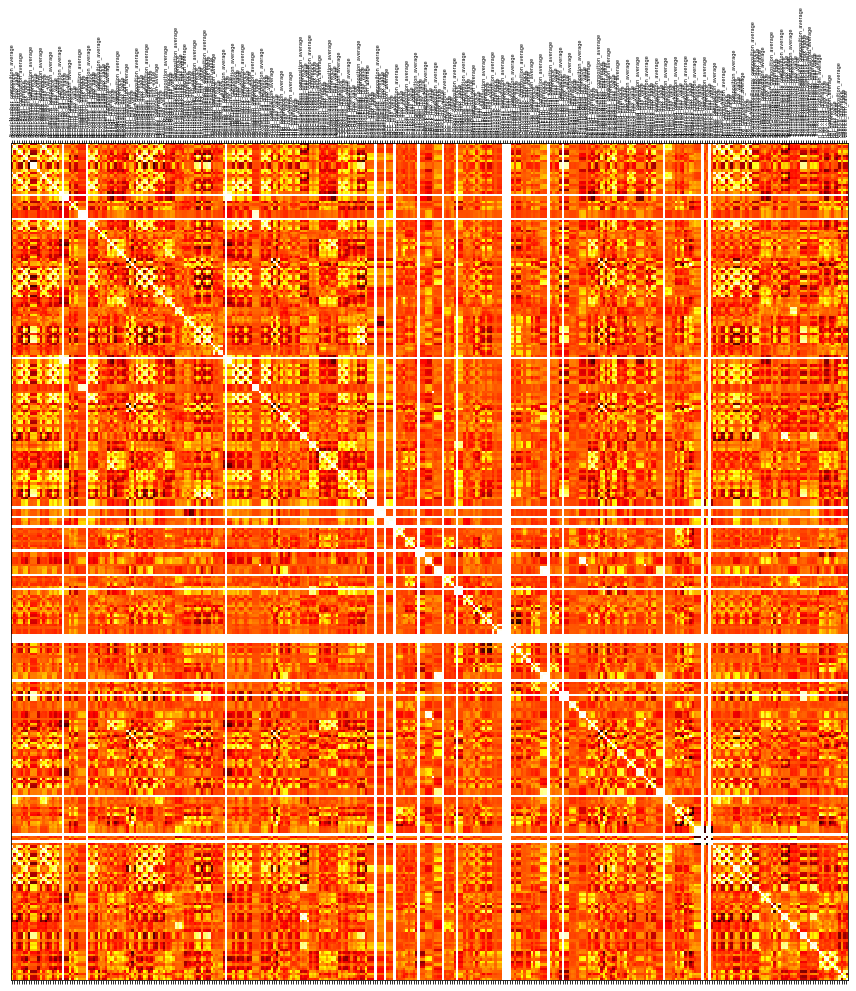

In [262]:
selected_df = features_df #features_df_filtered
## Correlation Matrix for the generated features
f = plt.figure(figsize=(15, 15))
corr = selected_df.corr(method='pearson') #corr[corr<=.95]
plt.matshow(corr,cmap='hot', fignum=f.number)
plt.xticks(range(selected_df.select_dtypes(['number']).shape[1]), selected_df.select_dtypes(['number']).columns, fontsize=5, rotation=90)
#plt.yticks(range(selected_df.select_dtypes(['number']).shape[1]), selected_df.select_dtypes(['number']).columns, fontsize=14)
plt.yticks([])
#plt.colorbar(aspect=50)
#cb.ax.tick_params(labelsize=14)

#plt.title('Correlation Matrix', fontsize=32);

/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/apps/share64/debian7/anaconda/anaconda-6/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


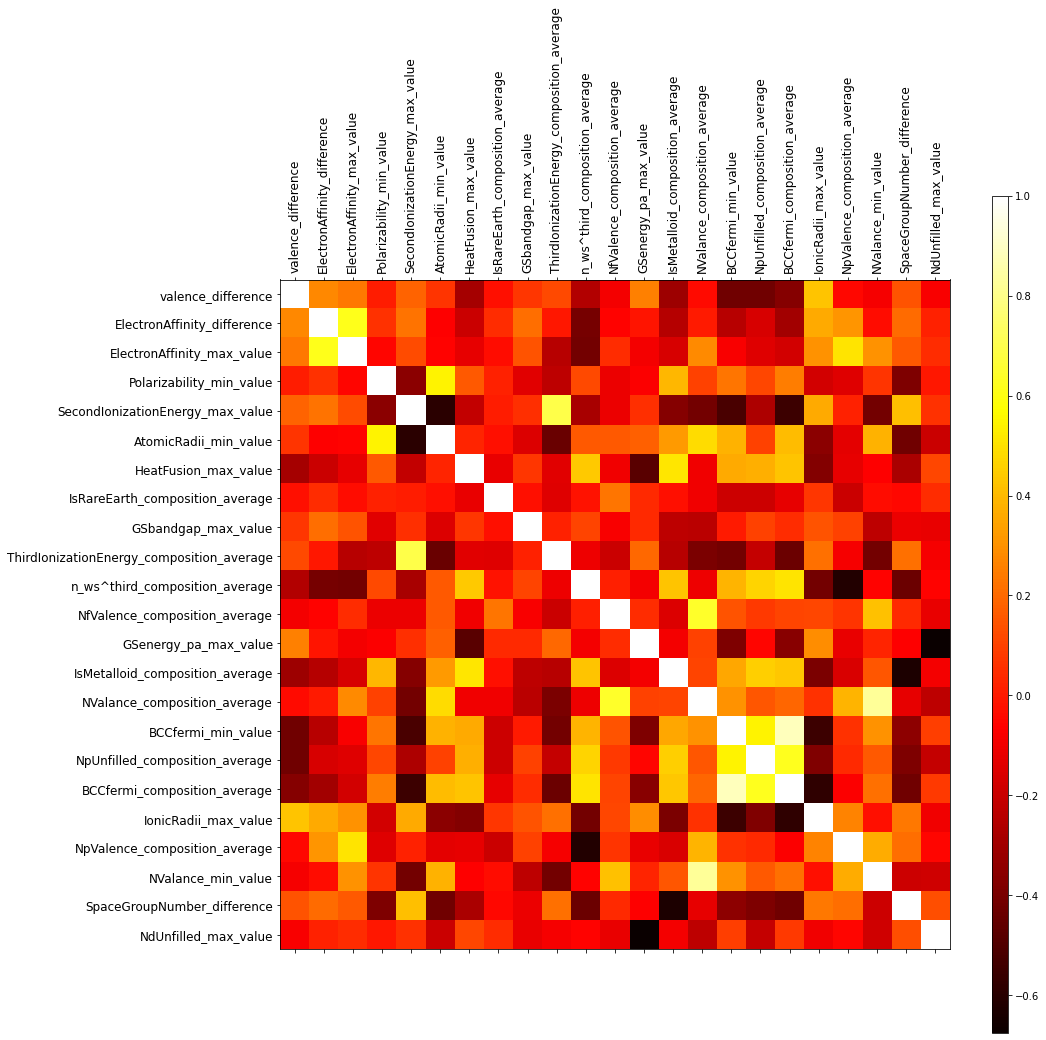

In [261]:
selected_df = features_df[test_comp2] #features_df_filtered
## Correlation Matrix for the generated features
f = plt.figure(figsize=(15, 15))
corr = selected_df.corr(method='pearson') #corr[corr<=.95]
plt.matshow(corr,cmap='hot', fignum=f.number)
plt.xticks(range(selected_df.select_dtypes(['number']).shape[1]), selected_df.select_dtypes(['number']).columns, fontsize=12, rotation=90)
plt.yticks(range(selected_df.select_dtypes(['number']).shape[1]), selected_df.select_dtypes(['number']).columns, fontsize=12)
#plt.yticks([])
plt.colorbar(aspect=50)
#cb.ax.tick_params(labelsize=14)

#plt.title('Correlation Matrix', fontsize=14);

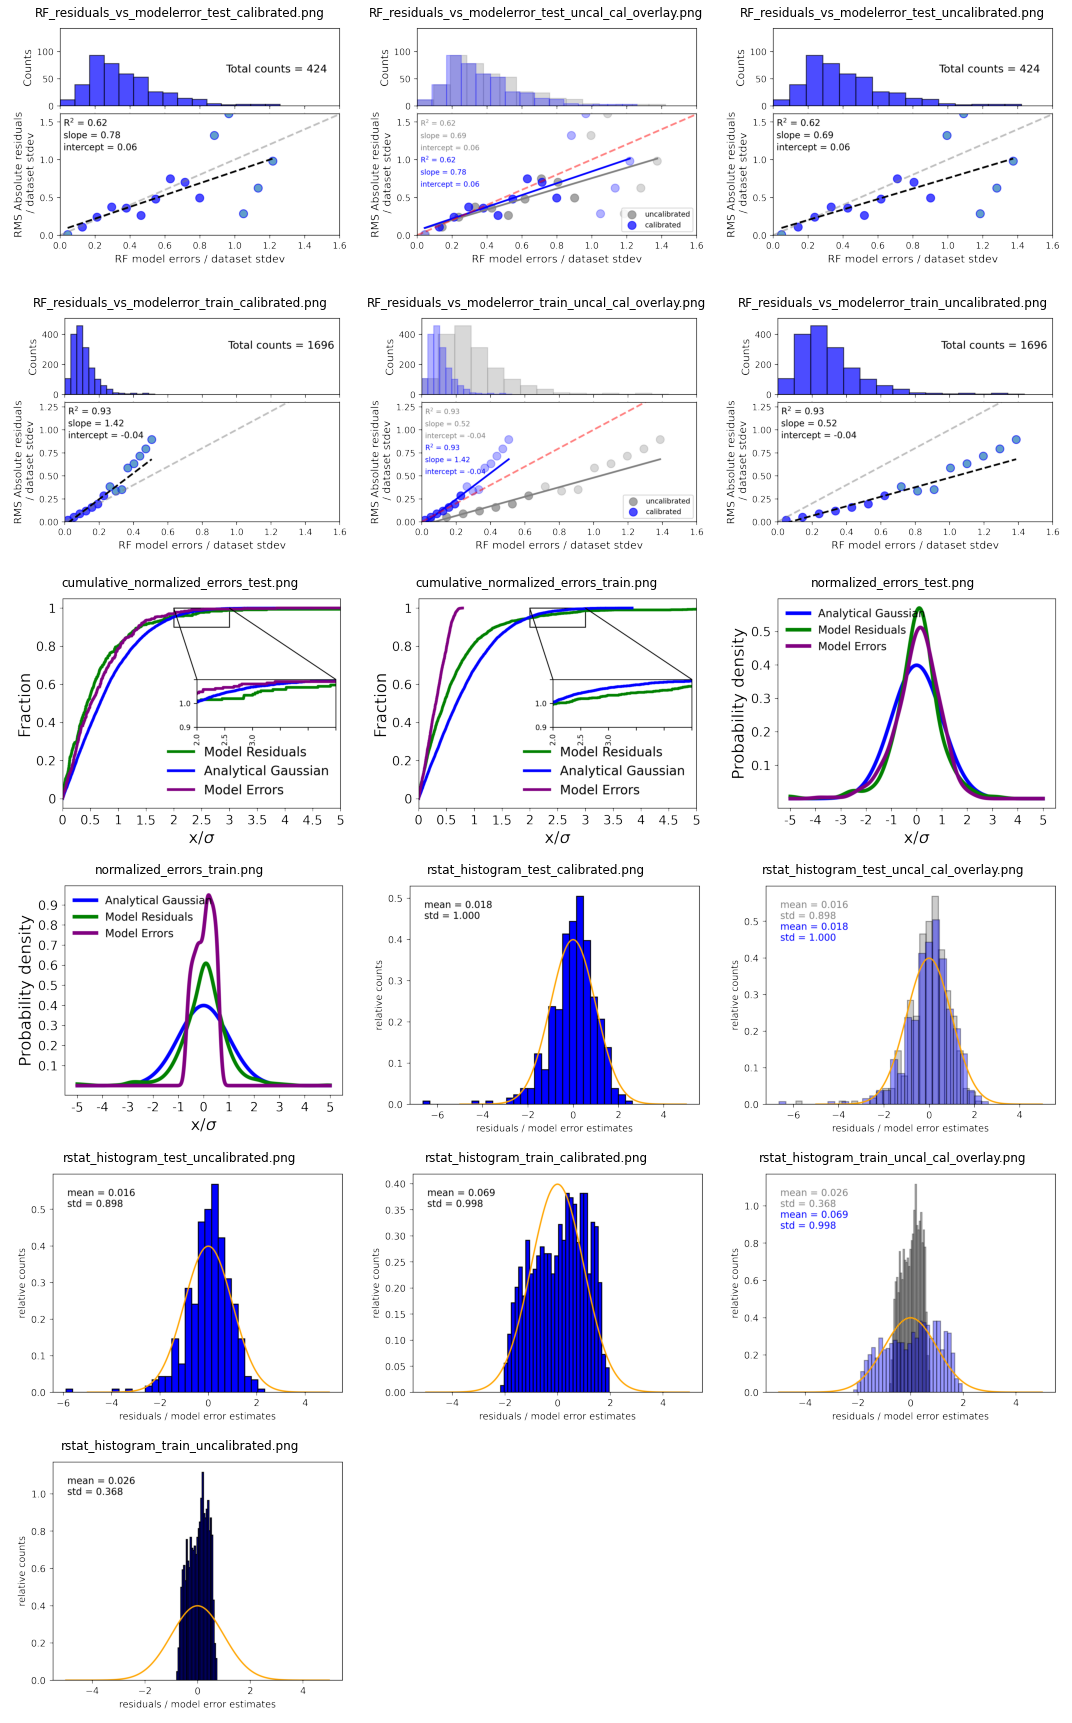

In [257]:
### create a list of png's in a folder, then use it to visualize
pngList = []
for files in os.listdir('./'+savepath+'/'+pathList[-1]):
    if '.png' in files:
        pngList.append(files)
pngList = sorted(pngList)
# FIGURE
plt.figure(figsize=(15,len(pngList)*4))
for png in range(len(pngList)):

    plt.subplot(len(pngList),3,png+1)
    img = plt.imread('./'+savepath+'/'+pathList[-1]+'/'+pngList[png])
    plt.imshow(img)
    ## Figure configurations
    plt.title(pngList[png])
    plt.axis('off')

In [661]:
y_pred_for = rf_reg_model.predict(X_test_for)

In [671]:
y_test_for.head()

y_test
0  1.430333
1  0.122000
2  0.780000
3  2.600000
4  5.900000

In [663]:
y_pred_for

0      5.966620
1      5.880526
2      5.868270
3      5.961558
4      5.936955
5      6.162039
6      5.817674
7      5.817674
8      5.817674
9      6.186003
10     5.948566
11     5.849194
12     5.949957
13     5.945410
14     5.919249
15     4.858192
16     5.814634
17     5.825070
18     5.831383
19     5.799058
20     5.859041
21     5.832349
22     5.809077
23     5.853057
24     5.853057
25     5.853057
26     5.893272
27     5.768381
28     5.863955
29     5.854249
         ...   
394    5.860221
395    5.941957
396    5.889913
397    5.882440
398    5.982495
399    5.849177
400    5.873456
401    4.786914
402    4.830763
403    4.830763
404    5.868465
405    4.690617
406    5.861487
407    5.929380
408    5.727438
409    4.792333
410    4.792328
411    5.832785
412    6.124134
413    6.146462
414    5.945178
415    4.841075
416    6.018332
417    5.876080
418    5.897870
419    5.971253
420    5.923767
421    5.828576
422    5.825952
423    5.927482
Name: y_pred, Length: 42

In [412]:
# calculate various metrics using sklearn.metrics library, for the last trained model/created folder
r2_score_adj_ = (1 - (1-r2_score)*(len(outputDf)-1)/(len(outputDf)-len(Xcopy.columns)-1))
print('Mean Absolute Error (MAE):', "%.3f"%sklearn.metrics.mean_absolute_error(test_df, pred_df))
print('Mean Squared Error (MSE):', "%.3f"%sklearn.metrics.mean_squared_error(test_df, pred_df))
print('Root Mean Squared Error (RMSE):', "%.3f"%sklearn.metrics.mean_squared_error(test_df, pred_df, squared=False))
print('Mean Absolute Percentage Error (MAPE):', "%.3f"%sklearn.metrics.mean_absolute_percentage_error(test_df, pred_df))
print('Explained Variance Score:', "%.3f"%sklearn.metrics.explained_variance_score(test_df, pred_df))
print('Max Error:', "%.3f"%sklearn.metrics.max_error(test_df, pred_df))
print('Mean Squared Log Error:', "%.3f"%sklearn.metrics.mean_squared_log_error(test_df, pred_df))
print('Median Absolute Error:', "%.3f"%sklearn.metrics.median_absolute_error(test_df, pred_df))
print('R^2:', "%.3f"%(sklearn.metrics.r2_score(test_df, pred_df)))
print('R^2_ADJ :', "%.3f"%(r2_score_adj_)) # %%% 
print('R^2_FPE :',"%.3f"%(((len(outputDf)+len(Xcopy.columns))*r2_score_adj_-len(Xcopy.columns))/(len(outputDf)+1)))
print('Mean Poisson Deviance:', "%.3f"%sklearn.metrics.mean_poisson_deviance(test_df, pred_df))
print('Mean Gamma Deviance:', "%.3f"%sklearn.metrics.mean_gamma_deviance(test_df, pred_df))

Mean Absolute Error (MAE): 0.622
Mean Squared Error (MSE): 0.737
Root Mean Squared Error (RMSE): 0.859
Mean Absolute Percentage Error (MAPE): 1.418
Explained Variance Score: 0.752
Max Error: 3.374
Mean Squared Log Error: 0.106
Median Absolute Error: 0.434
R^2: 0.736
R^2_ADJ : 0.723
R^2_FPE : 0.707
Mean Poisson Deviance: 0.434
Mean Gamma Deviance: 0.496


In [79]:
df_list[-1] # 

Formula   Band Gap  Predicted     Error  Error(%)
347      Bi0.7Sb0.3   0.008000   0.015033  0.001924    87.912
0      Bi0.85Sb0.15   0.008333   0.015360  0.009890    84.322
402  Sb0.605As0.395   0.009000   0.687445  0.467283  7538.282
1      Bi0.92Sb0.08   0.009000   0.014982  0.001844    66.466
2      Bi0.91Sb0.09   0.010000   0.012776  0.002267    27.755
3      Bi0.88Sb0.12   0.014000   0.015360  0.009890     9.715
4        Bi0.9Sb0.1   0.016250   0.015360  0.009890     5.476
5      Bi0.87Sb0.13   0.018000   0.012776  0.002267    29.025
6                Bi   0.019500   0.213741  0.346234   996.106
7              CrTe   0.020000   0.758809  0.597136  3694.044
8          BiSb0.15   0.022000   0.013282  0.001750    39.626
9      Bi0.97Sb0.03   0.022000   0.012776  0.002267    41.929
10            Ti2O3   0.035000   2.664690  2.065758  7513.401
354            CoSi   0.045000   0.609860  0.466995  1255.244
11            NiAs2   0.050000   0.468498  0.465798   836.995
12             WTe2   0.062500   0.531932  0.422810   751.091
13              NiS   0.065000   0.952622  0.764707  1365.572
14            Mg2Pb   0.070500   1.287212  1.377180  1725.833
15               Sn   0.082333   0.345167  0.372016   319.231
17           La2Te3   0.100000   1.167045  0.523050  1067.045
18             FeSi   0.100000   0.701617  0.395741   601.617
19           Mg3Bi2   0.100000   1.492433  1.426153  1392.433
16             V2O3   0.100000   0.472647  0.446762   372.647
401              Sb   0.100500   0.309663  0.441026   208.122
20            PtSb2   0.102400   0.352184  0.367780   243.930
366           FeSb2   0.110000   0.385110  0.365747   250.100
21            Nb2S3   0.120000   1.682256  0.771040  1301.880
22            ReSi2   0.120000   0.731723  0.567745   509.769
23            Ag2Se   0.122000   1.326774  0.526707   987.519
403    Sb0.71As0.29   0.125000   0.687445  0.467283   449.956
..              ...        ...        ...       ...       ...
312            CdF2   6.000000   4.553765  2.751642    24.104
313             NaI   6.074000   6.044019  1.522662     0.494
314             MnS   6.100000   2.520247  1.430151    58.684
315              KI   6.132778   6.087441  0.918224     0.739
316             RbI   6.174286   6.136958  1.261616     0.605
317             CsI   6.317500   6.131784  1.098872     2.940
318            LaF3   6.600000   4.788677  2.181312    27.444
357            CsBr   6.990000   7.345372  1.090895     5.084
319             CaO   7.066000   6.154565  2.984883    12.899
320             KBr   7.291875   7.528859  0.578117     3.250
321            NaBr   7.371250   7.392122  1.387264     0.283
322            RbBr   7.450000   7.405263  0.828620     0.600
323             MgO   7.620000   8.476209  2.574759    11.236
324            LiBr   7.725000   7.126454  1.755667     7.748
325            CsCl   7.950000   8.086990  1.170585     1.723
326            RbCl   8.278000   7.753717  1.066504     6.333
327             KCl   8.314000   8.446038  0.639303     1.588
328           Al2O3   8.493333   5.593947  3.213165    34.137
329            NaCl   8.673333   9.033635  1.673151     4.154
330            BaF2   9.060000   7.580831  2.379163    16.326
331            LiCl   9.330000   8.701321  1.516693     6.738
332            SiO2   9.450000   4.729778  2.322127    49.949
333            MgF2   9.837500   9.064402  2.363056     7.859
334             CsF  10.000000   9.063565  1.591144     9.364
335            CaF2  10.000000   8.534107  2.166951    14.659
336            MnF2  10.113333   3.322402  2.573251    67.148
398             RbF  10.400000   9.295319  1.197221    10.622
337              KF  10.427500  10.131720  0.938017     2.837
338             BeO  10.720000   6.366336  2.101467    40.613
339             LiF  12.435000   9.951426  0.666704    19.972

[424 rows x 5 columns]

In [80]:
#pd.DataFrame([df_list[0]["Predicted"].describe().round(3),df_list[1]["Predicted"].describe().round(3)]).T
#pd.DataFrame([df_list[0]["Error(%)"].describe().round(3),df_list[1]["Error(%)"].describe().round(3)]).T

In [81]:
# Compare results of models
#pd.DataFrame([df_list[0]["Error(%)"],df_list[1]["Error(%)"]]).T

In [162]:
# List of chemical formulas corresponding to accurate/low error predictions 
outputDf[abs(outputDf['Error(%)'])<1]['Formula']

110             RuSe2
129    Ge0.891Si0.109
370              GeSe
139             Eu3P2
141            Sb2Se3
363             Dy2O3
341             As2S5
233             BiBr3
253              TlBr
262               GaN
276              CBr4
321              NaBr
324              LiBr
Name: Formula, dtype: object

In [212]:
outputDf

Formula   Band Gap  Predicted  Error  Error(%)
347      Bi0.7Sb0.3   0.008000   0.020419 -0.012   155.242
0      Bi0.85Sb0.15   0.008333   0.019652 -0.011   135.824
402  Sb0.605As0.395   0.009000   0.639457 -0.630  7005.080
1      Bi0.92Sb0.08   0.009000   0.012332 -0.003    37.022
2      Bi0.91Sb0.09   0.010000   0.013631 -0.004    36.307
3      Bi0.88Sb0.12   0.014000   0.018020 -0.004    28.714
4        Bi0.9Sb0.1   0.016250   0.011240  0.005    30.831
5      Bi0.87Sb0.13   0.018000   0.018247 -0.000     1.372
6                Bi   0.019500   0.109857 -0.090   463.368
7              CrTe   0.020000   0.594722 -0.575  2873.608
8          BiSb0.15   0.022000   0.016161  0.006    26.542
9      Bi0.97Sb0.03   0.022000   0.014135  0.008    35.751
10            Ti2O3   0.035000   2.353402 -2.318  6624.005
354            CoSi   0.045000   0.636401 -0.591  1314.225
11            NiAs2   0.050000   0.621740 -0.572  1143.479
12             WTe2   0.062500   0.574266 -0.512   818.826
13              NiS   0.065000   1.636650 -1.572  2417.924
14            Mg2Pb   0.070500   1.216308 -1.146  1625.259
15               Sn   0.082333   0.516950 -0.435   527.875
17           La2Te3   0.100000   1.091078 -0.991   991.078
18             FeSi   0.100000   0.685538 -0.586   585.538
19           Mg3Bi2   0.100000   1.964523 -1.865  1864.523
16             V2O3   0.100000   1.056099 -0.956   956.099
401              Sb   0.100500   0.358520 -0.258   256.737
20            PtSb2   0.102400   0.419325 -0.317   309.497
366           FeSb2   0.110000   0.368127 -0.258   234.661
21            Nb2S3   0.120000   1.219656 -1.100   916.380
22            ReSi2   0.120000   0.812377 -0.692   576.981
23            Ag2Se   0.122000   1.269834 -1.148   940.847
403    Sb0.71As0.29   0.125000   0.620315 -0.495   396.252
..              ...        ...        ...    ...       ...
312            CdF2   6.000000   7.214313 -1.214    20.239
313             NaI   6.074000   5.783253  0.291     4.787
314             MnS   6.100000   1.263509  4.836    79.287
315              KI   6.132778   5.778985  0.354     5.769
316             RbI   6.174286   5.308972  0.865    14.015
317             CsI   6.317500   3.941313  2.376    37.613
318            LaF3   6.600000   7.087008 -0.487     7.379
357            CsBr   6.990000   7.368199 -0.378     5.411
319             CaO   7.066000   6.269694  0.796    11.270
320             KBr   7.291875   7.410477 -0.119     1.626
321            NaBr   7.371250   7.367275  0.004     0.054
322            RbBr   7.450000   7.129489  0.321     4.302
323             MgO   7.620000   6.118871  1.501    19.700
324            LiBr   7.725000   7.694118  0.031     0.400
325            CsCl   7.950000   8.217972 -0.268     3.371
326            RbCl   8.278000   8.127331  0.151     1.820
327             KCl   8.314000   8.400403 -0.086     1.039
328           Al2O3   8.493333   2.780053  5.713    67.268
329            NaCl   8.673333   7.015246  1.658    19.117
330            BaF2   9.060000   8.929691  0.130     1.438
331            LiCl   9.330000   8.804508  0.525     5.632
332            SiO2   9.450000   3.916731  5.533    58.553
333            MgF2   9.837500   7.286864  2.551    25.928
334             CsF  10.000000   9.542171  0.458     4.578
335            CaF2  10.000000   9.148311  0.852     8.517
336            MnF2  10.113333   6.564191  3.549    35.094
398             RbF  10.400000   9.856679  0.543     5.224
337              KF  10.427500  10.267686  0.160     1.533
338             BeO  10.720000   5.824768  4.895    45.664
339             LiF  12.435000   9.975243  2.460    19.781

[424 rows x 5 columns]

In [187]:
outputDf[abs(outputDf['Error(%)'])>100]

Formula  Band Gap  Predicted  Error  Error(%)
347      Bi0.7Sb0.3  0.008000   0.020419 -0.012   155.242
0      Bi0.85Sb0.15  0.008333   0.019652 -0.011   135.824
402  Sb0.605As0.395  0.009000   0.639457 -0.630  7005.080
6                Bi  0.019500   0.109857 -0.090   463.368
7              CrTe  0.020000   0.594722 -0.575  2873.608
10            Ti2O3  0.035000   2.353402 -2.318  6624.005
354            CoSi  0.045000   0.636401 -0.591  1314.225
11            NiAs2  0.050000   0.621740 -0.572  1143.479
12             WTe2  0.062500   0.574266 -0.512   818.826
13              NiS  0.065000   1.636650 -1.572  2417.924
14            Mg2Pb  0.070500   1.216308 -1.146  1625.259
15               Sn  0.082333   0.516950 -0.435   527.875
17           La2Te3  0.100000   1.091078 -0.991   991.078
18             FeSi  0.100000   0.685538 -0.586   585.538
19           Mg3Bi2  0.100000   1.964523 -1.865  1864.523
16             V2O3  0.100000   1.056099 -0.956   956.099
401              Sb  0.100500   0.358520 -0.258   256.737
20            PtSb2  0.102400   0.419325 -0.317   309.497
366           FeSb2  0.110000   0.368127 -0.258   234.661
21            Nb2S3  0.120000   1.219656 -1.100   916.380
22            ReSi2  0.120000   0.812377 -0.692   576.981
23            Ag2Se  0.122000   1.269834 -1.148   940.847
403    Sb0.71As0.29  0.125000   0.620315 -0.495   396.252
419            V5O9  0.150000   0.783698 -0.634   422.465
25           Bi2Te3  0.155444   0.642433 -0.487   313.288
423            Zr6O  0.180000   0.788684 -0.609   338.158
417            Tl2S  0.190000   1.393501 -1.204   633.421
27             PdSe  0.200000   0.695202 -0.495   247.601
28            MnSe2  0.200000   1.434639 -1.235   617.319
29             PtO2  0.200000   1.963386 -1.763   881.693
..              ...       ...        ...    ...       ...
391             PbS  0.343222   1.160761 -0.818   238.195
51            CrSi2  0.350000   0.912512 -0.563   160.718
52             InAs  0.386833   0.811949 -0.425   109.896
54             FeP2  0.400000   0.991881 -0.592   147.970
53              VO2  0.400000   0.811827 -0.412   102.957
55            PdSe2  0.400000   0.841606 -0.442   110.401
56            InAsI  0.410000   2.669863 -2.260   551.186
57             MnO2  0.413333   3.535340 -3.122   755.324
58           La3Te4  0.430000   1.073906 -0.644   149.746
59              WS2  0.450000   1.367656 -0.918   203.924
61             SmSe  0.460000   0.935423 -0.475   103.353
414            TbO2  0.500000   1.870831 -1.371   274.166
388            NiS2  0.500000   1.760073 -1.260   252.015
68            Cd3P2  0.568750   1.948494 -1.380   242.592
69            MnAl3  0.580000   1.480598 -0.901   155.275
70            Eu3O4  0.600000   2.345046 -1.745   290.841
72              CoO  0.600000   1.612754 -1.013   168.792
74           Tl2Te3  0.623333   1.353281 -0.730   117.104
395            PrO2  0.660000   1.856748 -1.197   181.325
80              AlB  0.686667   2.053944 -1.367   199.118
81            Cs3Bi  0.700000   2.277729 -1.578   225.390
82            Li3Bi  0.700000   2.657510 -1.958   279.644
392            PdS2  0.750000   1.534990 -0.785   104.665
100           In4S5  0.900000   1.979379 -1.079   119.931
111           Rb3Sb  1.000000   3.105289 -2.105   210.529
380           Li3Sb  1.000000   2.032437 -1.032   103.244
130            K3Sb  1.140000   3.009683 -1.870   164.007
131           Zn3P2  1.150000   2.397997 -1.248   108.521
145             EuN  1.250000   2.878658 -1.629   130.293
149               B  1.300000   4.160012 -2.860   220.001

[79 rows x 5 columns]

In [198]:
# Create a dataframe for predictions with low error rate
low_err_df = df_list[-1].drop(df_list[-1].loc[df_list[-1]['Error(%)'] > 10.0].index)
low_err_df.sort_values(by=['Error(%)'])

Formula   Band Gap  Predicted  Error  Error(%)
321            NaBr   7.371250   7.367275  0.004     0.054
139           Eu3P2   1.200000   1.200867 -0.001     0.072
341           As2S5   2.330000   2.334857 -0.005     0.208
233           BiBr3   2.660000   2.653704  0.006     0.237
324            LiBr   7.725000   7.694118  0.031     0.400
262             GaN   3.420000   3.404288  0.016     0.459
370            GeSe   1.200000   1.205856 -0.006     0.488
276            CBr4   3.700000   3.680319  0.020     0.532
110           RuSe2   1.000000   0.994054  0.006     0.595
363           Dy2O3   2.235000   2.221010  0.014     0.626
141          Sb2Se3   1.212500   1.220943 -0.008     0.696
129  Ge0.891Si0.109   1.126000   1.134292 -0.008     0.736
253            TlBr   3.084500   3.057113  0.027     0.888
327             KCl   8.314000   8.400403 -0.086     1.039
281           SnCl2   3.900000   3.856591  0.043     1.113
5      Bi0.87Sb0.13   0.018000   0.018247 -0.000     1.372
268           Sb2O3   3.570000   3.520992  0.049     1.373
308             LiI   5.840000   5.923981 -0.084     1.438
330            BaF2   9.060000   8.929691  0.130     1.438
154             TlS   1.360000   1.339697  0.020     1.493
337              KF  10.427500  10.267686  0.160     1.533
320             KBr   7.291875   7.410477 -0.119     1.626
378           In2S3   1.803333   1.772808  0.031     1.693
326            RbCl   8.278000   8.127331  0.151     1.820
225            AsI3   2.415000   2.370805  0.044     1.830
138            FeS2   1.200000   1.222023 -0.022     1.835
218           As2S6   2.350000   2.394678 -0.045     1.901
258           PbBr2   3.310000   3.244867  0.065     1.968
224            SnI2   2.400000   2.449268 -0.049     2.053
95             AgTe   0.850000   0.832321  0.018     2.080
..              ...        ...        ...    ...       ...
412            SrSe   4.435000   4.722707 -0.288     6.487
368          Ga2Te3   1.301667   1.386740 -0.085     6.536
283           PbCl2   3.953333   3.694469  0.259     6.548
86             AsTe   0.740000   0.691079  0.049     6.611
275            AgN3   3.670000   3.922761 -0.253     6.887
348           Bi2O3   2.663333   2.850479 -0.187     7.027
278            CdI2   3.772900   3.501287  0.272     7.199
117            NdAs   1.040000   1.115751 -0.076     7.284
318            LaF3   6.600000   7.087008 -0.487     7.379
358            Cu2S   1.590000   1.708667 -0.119     7.463
226            HfS2   2.430000   2.246486  0.184     7.552
156             InP   1.388500   1.493440 -0.105     7.558
91             MnSi   0.800000   0.863471 -0.063     7.934
360             CuI   3.058500   2.808361  0.250     8.179
373           HfSe2   1.665000   1.527748  0.137     8.243
265            TlCl   3.497000   3.204141  0.293     8.375
190  Ge0.653Si0.347   1.914000   1.752004  0.162     8.464
266            ErB6   3.500000   3.798034 -0.298     8.515
335            CaF2  10.000000   9.148311  0.852     8.517
119    Ge0.93Si0.07   1.042000   1.135301 -0.093     8.954
140            OsP2   1.200000   1.092039  0.108     8.997
247            AgBr   2.979273   3.255646 -0.276     9.277
364             EuS   1.946000   2.127087 -0.181     9.306
67            PtAs2   0.550000   0.498606  0.051     9.344
307             SrO   5.735000   6.271545 -0.537     9.356
397           PrTe2   1.154000   1.264546 -0.111     9.579
236            ZnSe   2.764833   3.031975 -0.267     9.662
344            AsSe   1.215000   1.096184  0.119     9.779
173           Sb2S3   1.715556   1.883605 -0.168     9.796
120           ZnAs2   1.043333   1.147050 -0.104     9.941

[102 rows x 5 columns]

In [82]:
#Create a dataframe of predictions with low error
output_Df2 = df_list[-1].drop(df_list[-1].loc[df_list[-1]['Error(%)'] > 10].index)
output_Df2.head()

Formula  Band Gap  Predicted     Error  Error(%)
3    Bi0.88Sb0.12   0.01400   0.015360  0.009890     9.715
4      Bi0.9Sb0.1   0.01625   0.015360  0.009890     5.476
63         Fe2Te3   0.47000   0.448165  0.333477     4.646
67          PtAs2   0.55000   0.532867  0.502089     3.115
396          PrSb   0.66000   0.678694  0.387527     2.832

In [83]:
#print(mastml_df_clean[mastml_df_clean["Band gap"]<0.5].count())
#outputDf[abs(outputDf['Error(%)']<10)].count()[-1]
## https://www.javatpoint.com/supervised-machine-learning

In [84]:
df_list[-1].max()

Formula        ZrSe3
Band Gap      12.435
Predicted    10.1317
Error        3.21317
Error(%)     7538.28
dtype: object

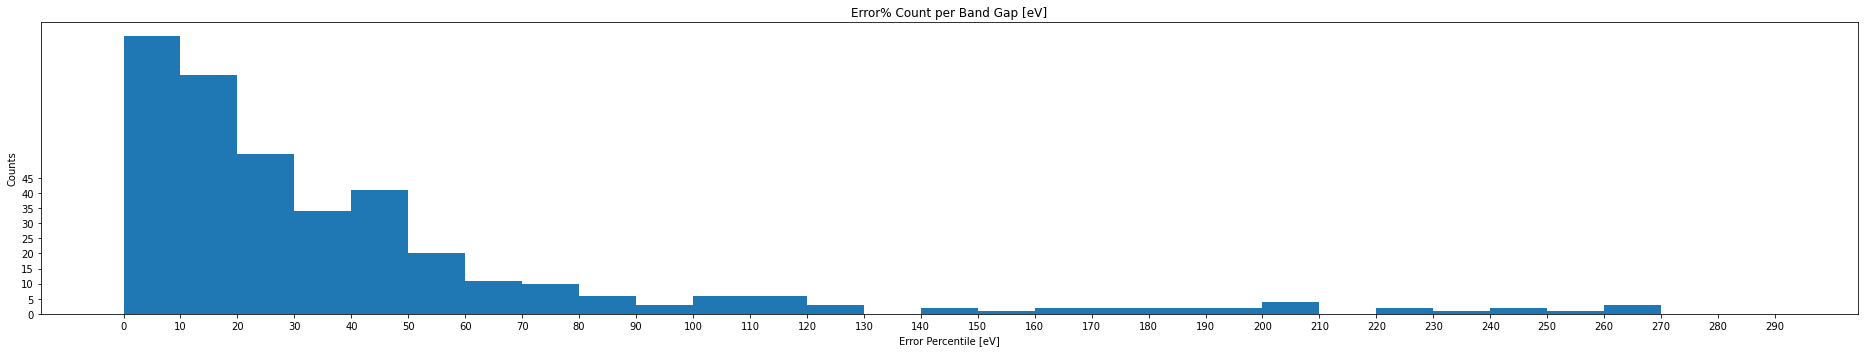

In [86]:
### PLOTS %Error count
plot_limit = 300
fig1,ax1 = plt.subplots(figsize=(26,5))
ax1.hist(df_list[-1]['Error(%)'],bins=np.arange(0,plot_limit,10),density=0) #density=1 gives % counts 
ax1.set_xticks(np.arange(0,plot_limit,10))
ax1.set_yticks(np.arange(0,50,5))
ax1.set_xlabel('Error Percentile [eV]')
ax1.set_ylabel('Counts')
plt.title('Error% Count per Band Gap [eV]')
plt.show()


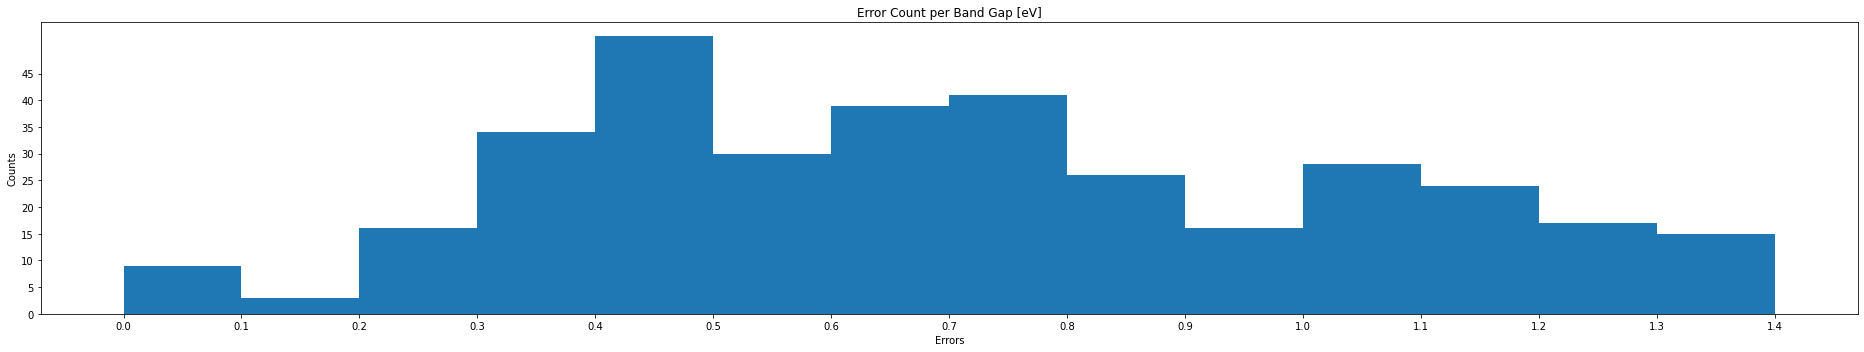

In [87]:
### PLOTS Error count
plot_limit = 1.5
fig1,ax1 = plt.subplots(figsize=(26,5))
ax1.hist(outputDf['Error'],bins=np.arange(0,plot_limit,0.1),density=0) #density=1 gives % counts 
ax1.set_xticks(np.arange(0,plot_limit,0.1))
ax1.set_yticks(np.arange(0,50,5))
ax1.set_xlabel('Errors')
ax1.set_ylabel('Counts')
plt.title('Error Count per Band Gap [eV]')
plt.show()


Text(0.5, 1.0, 'Scatter Plot with Errors in [eV]')

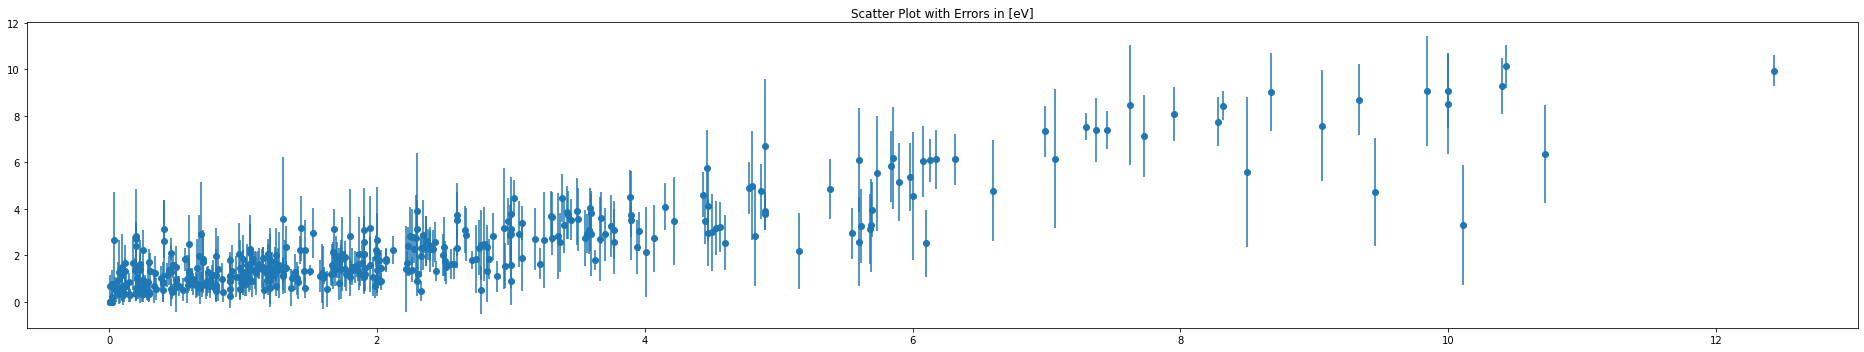

In [88]:
plot_limit = 5 #[eV]
df_idx = -1 #-1 for last trained model

fig1,ax1 = plt.subplots(figsize=(26,5))
#ax1.set_xticks(np.arange(0,plot_limit,0.1))
ax1.errorbar(df_list[df_idx]['Band Gap'], df_list[df_idx]['Predicted'], yerr=df_list[df_idx]['Error'], fmt='o')
plt.title('Scatter Plot with Errors in [eV]')

Text(0.5, 1.0, 'Model Fit')

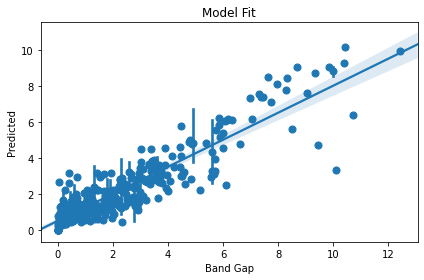

In [89]:
## linear fit plot with confidence interval ## All data
sns.regplot(x="Band Gap", y="Predicted", data=outputDf, x_estimator=np.mean) 
#sns.lmplot(x="Band Gap", y="Predicted", data=outputDf, x_estimator=np.mean)
plt.title('Model Fit')

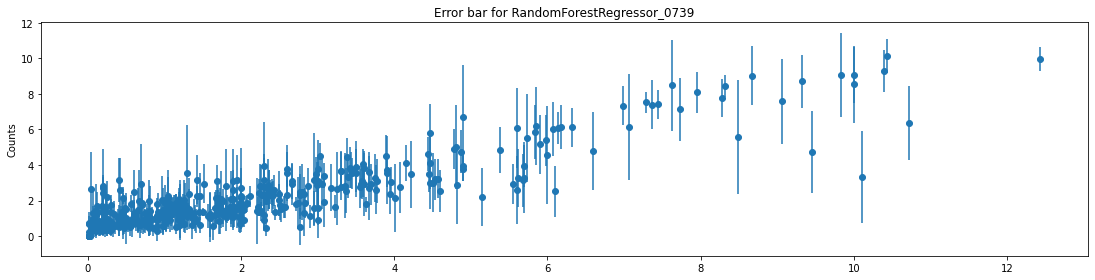

In [92]:
### Error bar plot

plt.figure(figsize=(30,len(df_list)*4))
for df_idx in range(len(df_list)):
    #outputDf2 = df_list['Band Gap']
    
    plt.subplot(len(df_list),2,df_idx+1)
    plt.errorbar(df_list[df_idx]['Band Gap'], df_list[df_idx]['Predicted'], yerr=df_list[df_idx]['Error'], fmt='o')
    plt.ylabel('Counts')
    plt.title('Error bar for '+file_df['Model'].iloc[df_idx]+'_'+file_df['HH'].iloc[df_idx]+file_df['mm'].iloc[df_idx])
    #plt.legend(loc='upper right')

In [155]:
# (:)